#### 환경설정

##### 1. Wandb

In [ ]:
import wandb

# wandb 로그인
wandb.login(key="2fb604788cd6eed5aafafcc8d13a6aaa7737ac71")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ressera3/.netrc
wandb: Currently logged in as: boaz_woony (boaz_woony-boaz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

##### 2. 라이브러리 로드

In [2]:

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import math
import random
import pickle
import wandb
from tqdm import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import torchvision
import torchvision.models as models
from torch import Tensor
from torchsummary import summary
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE

##### 3. 경로 설정

In [ ]:
ROOT = "/home/HyeonSeok/BOAZ-Chungzins/data/raw"
CHECKPOINT_PATH = "/home/HyeonSeok/BOAZ-Chungzins/save_path/checkpoint"
PICKLE_PATH = "/home/HyeonSeok/BOAZ-Chungzins/save_path/pickle"
text = "/home/HyeonSeok/BOAZ-Chungzins/data/metadata/train_test_split.txt"

##### 4. Seed 설정

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything(42) # Seed 고정

## 1. Data Load

#### 1.1 Data Load

In [6]:
# WAV 파일이 있는 디렉토리 경로
data_dir = ROOT
txt_dir = ROOT

df = pd.read_csv(text, sep='\t', header=None)

# 컬럼 이름 변경
df.columns = ['filename', 'set']

# train, test split
train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

# filename list
train_list = sorted(train_df['filename'].tolist())
test_list = sorted(test_df['filename'].tolist())

print(f'Train :{len(train_list)}, Test: {len(test_list)}, Total: {len(train_list) + len(test_list)}')

Train :539, Test: 381, Total: 920


#### 1.2 Pretext-Finetune Split

In [7]:
# shuffle train data
df_shuffled = train_df.sample(frac=1, random_state=42)

# split ratio
train_size = int(len(df_shuffled))

# pretrain, finetune split
pretrain_df = df_shuffled[:train_size]
finetune_df = pretrain_df

# filename list (pretext_list -> pretrain list)
pretrain_list = sorted(pretrain_df['filename'].tolist())
finetune_list = sorted(finetune_df['filename'].tolist())

# patient id list
pretrain_patient_list = []
for filename in pretrain_list:
    number = int(filename.split('_')[0])
    pretrain_patient_list.append(number)

finetune_patient_list = []
for filename in finetune_list:
    number = int(filename.split('_')[0])
    finetune_patient_list.append(number)

pretrain_patient_counts = pd.Series(pretrain_patient_list).value_counts()
finetune_patient_counts = pd.Series(finetune_patient_list).value_counts()

print(f"[Pretrain] 환자 수: {len(pretrain_patient_counts.index)}, 샘플 수: {pretrain_patient_counts.sum()}")
print(f"[Finetune] 환자 수: {len(finetune_patient_counts.index)}, 샘플 수: {finetune_patient_counts.sum()}")

[Pretrain] 환자 수: 79, 샘플 수: 539
[Finetune] 환자 수: 79, 샘플 수: 539


## 2. Data Preprocessing

#### 2.1 Args

        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)

In [8]:
class Args:
    # Audio & Spectrogram
    target_sr = 16000    # 4KHz
    frame_size = 1024
    hop_length = 512    # frame_size 절반
    n_mels = 64
    target_sec = 8

    # Augmentation
    time_mask_param = 0.5
    freq_mask_param = 0.5

    # Train
    lr = 0.001 # adamw - 0.03
    warm = True                     # warm-up 사용 여부
    warm_epochs = 10                # warm-up 적용할 초기 epoch 수
    warmup_from = lr * 0.1          # warm-up 시작 learning rate (보통 lr의 10%)
    warmup_to = lr

    batch_size = 128
    workers = 2
    epochs = 200
    weight_decay = 1e-4

    resume = None
    schedule=[120, 160] # schedule

    # MLS
    K = 512
    momentum = 0.999
    T = 0.07
    dim_prj = 128
    top_k = 20
    lambda_bce = 0.3
    out_dim = 2048

    # Linear Evaluation
    ft_epochs = 3

    # etc
    gpu = 0
    data = "./data_path"
    seed=42

args = Args()

#### 2.2 Utils (func)

In [9]:
import torch.nn.functional as F
import random

# cycle의 클래스를 추출
def get_class(cr, wh):
    if cr == 1 and wh == 1:
        return 3
    elif cr == 0 and wh == 1:
        return 2
    elif cr == 1 and wh == 0:
        return 1
    elif cr == 0 and wh == 0:
        return 0
    else:
        return -1

# Mel Spectrogram 생성 ( sr=4KHz, frame_size=1024, hop_length=512, n_mels=128 )
# def generate_mel_spectrogram(waveform, sample_rate, frame_size, hop_length, n_mels):
#     if hop_length is None:
#         hop_length = frame_size // 2
#     mel_spec_transform = T.MelSpectrogram(
#         sample_rate=sample_rate,
#         n_fft=frame_size,
#         hop_length=hop_length,
#         n_mels=n_mels,
#         f_min=50,       # 논문 기준 주파수 범위 하한
#         f_max=2000      # 논문 기준 주파수 범위 상한
#     )
#     mel_spectrogram = mel_spec_transform(waveform)
#     mel_db = T.AmplitudeToDB()(mel_spectrogram)
    
#     # dB 스케일에서 매우 낮은 값은 0으로 마스킹
#     mel_db[mel_db <= -100.0] = 0.0
    
#     return mel_db

# 256 맟춰주기
def generate_mel_spectrogram(waveform, sample_rate, frame_size, hop_length, n_mels):
    if hop_length is None:
        hop_length = frame_size // 2

    mel_spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=frame_size,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=50,
        f_max=2000
    )
    mel_spectrogram = mel_spec_transform(waveform)
    mel_db = T.AmplitudeToDB()(mel_spectrogram)

    # dB 스케일에서 매우 낮은 값은 0으로 마스킹
    mel_db[mel_db <= -100.0] = 0.0

    # 🔧 가운데 padding 적용
    target_frames = 256
    current_frames = mel_db.shape[-1]
    if current_frames < target_frames:
        pad_total = target_frames - current_frames
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        mel_db = F.pad(mel_db, (pad_left, pad_right))  # center padding
    elif current_frames > target_frames:
        # 가운데 자르기
        start = (current_frames - target_frames) // 2
        mel_db = mel_db[:, :, start:start + target_frames]

    return mel_db

# Cycle Repeat 또는 Crop
def repeat_or_truncate_segment(mel_segment, target_frames):
    current_frames = mel_segment.shape[-1]
    if current_frames >= target_frames:
        return mel_segment[:, :, :target_frames]
    else:
        repeat_ratio = math.ceil(target_frames / current_frames)
        mel_segment = mel_segment.repeat(1, 1, repeat_ratio)
        return mel_segment[:, :, :target_frames]

def preprocess_waveform_segment(waveform, unit_length):

    """unit_length 기준으로 waveform을 repeat + padding 또는 crop하여 길이 정규화"""
    waveform = waveform.squeeze(0)  # (1, L) → (L,) 로 바꿔도 무방
    length_adj = unit_length - len(waveform)

    if length_adj > 0:
        # waveform이 너무 짧은 경우 → repeat + zero-padding
        half_unit = unit_length // 2

        if length_adj < half_unit:
            # 길이 차이가 작으면 단순 padding
            half_adj = length_adj // 2
            waveform = F.pad(waveform, (half_adj, length_adj - half_adj))
        else:
            # 반복 후 부족한 부분 padding
            repeat_factor = unit_length // len(waveform)
            waveform = waveform.repeat(repeat_factor)[:unit_length]
            remaining = unit_length - len(waveform)
            half_pad = remaining // 2
            waveform = F.pad(waveform, (half_pad, remaining - half_pad))
    else:
        # waveform이 너무 길면 앞쪽 1/4 내에서 랜덤 crop
        length_adj = len(waveform) - unit_length
        start = random.randint(0, length_adj // 4)
        waveform = waveform[start:start + unit_length]

    return waveform.unsqueeze(0)  # 다시 (1, L)로

# # 논문 기반: Circular padding 방식 적용
# # - waveform이 짧은 경우: circular padding으로 8초 길이 맞춤
# # - waveform이 긴 경우: 앞쪽 25% 범위 내에서 랜덤 crop
# def preprocess_waveform_segment(waveform, unit_length):
#     """
#     논문 기반: Circular padding 적용
#     - waveform이 짧은 경우: circular padding으로 8초 길이 맞춤
#     - waveform이 긴 경우: 앞쪽 25% 범위 내에서 랜덤 crop
#     """
#     waveform = waveform.squeeze(0)  # (1, L) → (L,)
#     current_len = waveform.size(0)

#     if current_len < unit_length:
#         pad_len = unit_length - current_len
#         # ➤ shape을 (1, L)로 바꾸고 pad 적용 후 다시 (L,)로
#         waveform = waveform.unsqueeze(0)  # (L,) → (1, L)
#         waveform = F.pad(waveform, (0, pad_len), mode='circular')
#         waveform = waveform.squeeze(0)    # (1, L+pad) → (L+pad,)
#     elif current_len > unit_length:
#         max_start = max(0, current_len - unit_length)
#         start = random.randint(0, max_start // 4)
#         waveform = waveform[start:start + unit_length]

#     return waveform.unsqueeze(0)  # (L,) → (1, L)

# 데이터 Spec Augmentation ( 0~80% Random Masking )
def apply_spec_augment(mel_segment):

    M = mel_segment.shape[-1]
    F = mel_segment.shape[-2]

    # torchaudio의 마스킹은 0부터 mask_param까지 균등분포에서 랜덤하게 길이를 선택
    time_masking = T.TimeMasking(time_mask_param=int(M * 0.8))
    freq_masking = T.FrequencyMasking(freq_mask_param=int(F * 0.8) )

    aug1 = freq_masking(mel_segment.clone())
    aug2 = time_masking(mel_segment.clone())
    aug3 = freq_masking(time_masking(mel_segment.clone()))

    return aug1, aug2, aug3

# Waveform resample
def resample_waveform(waveform, orig_sr, target_sr=args.target_sr):
    if orig_sr != target_sr:
        resampler = torchaudio.transforms.Resample(
            orig_freq=orig_sr,
            new_freq=target_sr
        )
        return resampler(waveform), target_sr
    return waveform, orig_sr

# Normalize - Mean/Std
# def get_mean_and_std(dataset):
#     """ 전체 mel-spectrogram에서 mean과 std 계산 """
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

#     cnt = 0
#     fst_moment = torch.zeros(1)
#     snd_moment = torch.zeros(1)
#     for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
#         b, c, h, w = inputs.shape  # inputs: [1, 1, n_mels, time]
#         nb_pixels = b * h * w

#         fst_moment += torch.sum(inputs, dim=[0, 2, 3])
#         snd_moment += torch.sum(inputs**2, dim=[0, 2, 3])
#         cnt += nb_pixels

#     mean = fst_moment / cnt
#     std = torch.sqrt(snd_moment / cnt - mean**2)
#     return mean.item(), std.item()

def get_mean_and_std(dataset, mask_threshold=-99.0):
    """ 마스킹(-100 등)을 제외하고 mean/std 계산 """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

    cnt = 0
    fst_moment = 0.0
    snd_moment = 0.0

    for inputs, _, _ in tqdm(dataloader, desc="[Calculating Mean/Std]"):
        # mask: 유효한 mel 값만 추출 (e.g. > -99.0)
        valid = inputs[inputs > mask_threshold]  # 1D tensor

        fst_moment += valid.sum().item()
        snd_moment += (valid ** 2).sum().item()
        cnt += valid.numel()

    mean = fst_moment / cnt
    std = np.sqrt(snd_moment / cnt - mean**2)
    return mean, std

In [10]:
# import torch
# import torch.nn.functional as F
# import torchaudio.transforms as T
# import numpy as np
# import random
# import math

# # -------------------- Augmentation functions (Torch 기반) --------------------

# def spec_augment(mel, time_mask_ratio, freq_mask_ratio): # default: 0.8
#     M = mel.shape[-1]  # 시간 축
#     F = mel.shape[-2]  # 주파수 축

#     time_masking = T.TimeMasking(time_mask_param=int(M * time_mask_ratio))
#     freq_masking = T.FrequencyMasking(freq_mask_param=int(F * freq_mask_ratio))

#     mel = freq_masking(mel.clone())
#     mel = time_masking(mel)
#     return mel

# # def random_crop(mel, crop_size):
# #     if mel.shape[-1] <= crop_size:
# #         return mel
# #     start = torch.randint(0, mel.shape[-1] - crop_size + 1, (1,)).item()
# #     return mel[:, :, start:start + crop_size]

# def add_noise(mel, noise_level=0.005):
#     noise = torch.randn_like(mel) * noise_level
#     return mel + noise

# def pitch_shift(mel, n_steps=2):
#     shift = random.randint(-n_steps, n_steps)
#     if shift == 0:
#         return mel
#     if shift > 0:
#         mel = torch.cat([mel[:, shift:, :], mel[:, :shift, :]], dim=1)
#     else:
#         shift = abs(shift)
#         mel = torch.cat([mel[:, -shift:, :], mel[:, :-shift, :]], dim=1)
#     return mel

# def time_stretch(mel, min_rate=0.8, max_rate=1.2):
#     rate = random.uniform(min_rate, max_rate)
#     if rate == 1.0:
#         return mel

#     orig_size = mel.shape[-1]
#     target_size = int(orig_size * rate)
#     mel_stretched = F.interpolate(
#         mel, size=(mel.shape[1], target_size),
#         mode='bilinear', align_corners=False
#     )

#     if target_size > orig_size:
#         return mel_stretched[:, :, :orig_size]
#     else:
#         padding = orig_size - target_size
#         return F.pad(mel_stretched, (0, padding))

# # -------------------- Dispatcher --------------------

# AUGMENTATION_FUNCTIONS_TORCH = {
#     "spec_augment": spec_augment,
#     # "random_crop": random_crop,
#     "add_noise": add_noise,
#     "pitch_shift": pitch_shift,
#     "time_stretch": time_stretch
# }

# def apply_augmentations_torch(x, methods=[], **kwargs):
#     for method in methods:
#         func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
#         if func is None:
#             raise ValueError(f"Unknown augmentation: {method}")
#         x = func(x, **kwargs.get(method, {}))
#     return x


##############################################
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import numpy as np
import random

# -------------------- Augmentation functions (ICBHI 멜스펙트로그램에 최적화) --------------------

# def spec_augment(mel, time_mask_ratio=0.15, freq_mask_ratio=0.15):
#     """
#     SpecAugment: 시간/주파수 영역 마스킹
#     - 시간축 마스킹: 63 * 0.15 ≈ 9 프레임
#     - 주파수 마스킹: 128 * 0.1 ≈ 12 채널
#     """
#     M = mel.shape[-1]  # 시간 축
#     F = mel.shape[-2]  # 주파수 축

#     time_masking = T.TimeMasking(time_mask_param=max(1, int(M * time_mask_ratio)))
#     freq_masking = T.FrequencyMasking(freq_mask_param=max(1, int(F * freq_mask_ratio)))

#     mel = freq_masking(mel.clone())
#     mel = time_masking(mel)
#     return mel

# multi-label 논문용 spec
def spec_augment(mel, time_mask_param=20, freq_mask_param=40):
    """
    논문 기준:
    - 시간 마스킹: 최대 20 frame
    - 주파수 마스킹: 최대 40 mel bin
    """
    time_masking = T.TimeMasking(time_mask_param=time_mask_param)
    freq_masking = T.FrequencyMasking(freq_mask_param=freq_mask_param)

    mel = freq_masking(mel.clone())
    mel = time_masking(mel)
    return mel

def add_noise(mel, noise_level=0.001):
    """
    노이즈 추가: 적당한 수준의 표준 정규분포 노이즈 (너무 높으면 손실 커짐)
    """
    noise = torch.randn_like(mel) * noise_level
    return mel + noise

def pitch_shift(mel, n_steps=2):
    """
    주파수 축 순환 이동 (mel axis). shape은 그대로 유지됨.
    n_steps=2면 ±2 멜 채널만 이동.
    """
    shift = random.randint(-n_steps, n_steps)
    if shift == 0:
        return mel
    if shift > 0:
        mel = torch.cat([mel[:, :, shift:, :], mel[:, :, :shift, :]], dim=2)
    else:
        shift = abs(shift)
        mel = torch.cat([mel[:, :, -shift:, :], mel[:, :, :-shift, :]], dim=2)
    return mel

def time_stretch(mel, min_rate=0.95, max_rate=1.05):
    """
    시간 축 길이 조절. 너무 심하지 않게 ±5% 범위로만 조정.
    - shape 유지 위해 interpolation 후 crop/pad
    """
    rate = random.uniform(min_rate, max_rate)
    if rate == 1.0:
        return mel

    orig_size = mel.shape[-1]
    target_size = int(orig_size * rate)

    mel_stretched = F.interpolate(
        mel, size=(mel.shape[-2], target_size),  # (mel_bins, time)
        mode='bilinear',
        align_corners=False
    )

    if target_size > orig_size:
        return mel_stretched[..., :orig_size]
    else:
        pad = orig_size - target_size
        return F.pad(mel_stretched, (0, pad))

# -------------------- Dispatcher --------------------

AUGMENTATION_FUNCTIONS_TORCH = {
    "spec_augment": spec_augment,
    "add_noise": add_noise,
    "pitch_shift": pitch_shift,
    "time_stretch": time_stretch
}

def apply_augmentations_torch(x, methods=[], **kwargs):
    for method in methods:
        func = AUGMENTATION_FUNCTIONS_TORCH.get(method)
        if func is None:
            raise ValueError(f"Unknown augmentation: {method}")
        x = func(x, **kwargs.get(method, {}))
    return x


In [11]:
def aug(repeat_mel):
    # 먼저 복사본 준비
    mel1 = repeat_mel.clone()
    mel2 = repeat_mel.clone()

    # 각각 다른 증강 A, B 적용
    # aug1 = apply_augmentations_torch(mel1, methods=["add_noise"], add_noise={"noise_level": 0.005})
    # aug2 = apply_augmentations_torch(mel2, methods=["time_stretch"], time_stretch={"min_rate": 0.8, "max_rate": 1.2})
    # aug3 = apply_augmentations_torch(mel2, methods=["pitch_shift"], pitch_shift={"n_steps": 2})

    # # 각 결과에 spec_augment 추가 적용
    # aug1_spec = spec_augment(aug1)
    # aug2_spec = spec_augment(aug2, time_mask_ratio=0.6, freq_mask_ratio=0.4)
    # aug3_spec = spec_augment(aug3)

    ## 순수 spec_augment만 적용한 경우
    aug_speconly = spec_augment(mel1)

    return aug_speconly, None, None


def get_timestamp():
    """Outputs current time in KST like 2404070830"""
    kst_time = datetime.now(ZoneInfo("Asia/Seoul"))
    return kst_time.strftime('%y%m%d%H%M')

# Origin
# def aug(repeat_mel):
#     aug1, aug2, aug3 = apply_spec_augment(repeat_mel)
#     return aug1, aug2, aug3

#### 2.3 CycleDataset

In [12]:
import os
import torch
import torchaudio
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm import tqdm

class CycleDataset(Dataset):
    def __init__(self, filename_list, wav_dir, txt_dir, target_sec=args.target_sec, target_sr=args.target_sr, frame_size=args.frame_size, hop_length=args.hop_length, n_mels=args.n_mels, mean=None, std=None):
        self.filename_list = filename_list
        self.wav_dir = wav_dir
        self.txt_dir = txt_dir
        self.target_sec = target_sec
        self.target_sr = target_sr
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mean = mean
        self.std = std

        self.cycle_list = []

        print("[INFO] Preprocessing cycles...")
        for filename in tqdm(self.filename_list):
            txt_path = os.path.join(self.txt_dir, filename + '.txt')
            wav_path = os.path.join(self.wav_dir, filename + '.wav')

            if not os.path.exists(txt_path):
                print(f"[WARNING] Missing file: {txt_path}")
            if not os.path.exists(wav_path):
                print(f"[WARNING] Missing file: {wav_path}")

            # Load annotation
            cycle_data = np.loadtxt(txt_path, usecols=(0, 1))
            lung_label = np.loadtxt(txt_path, usecols=(2, 3))

            # Load waveform
            waveform, orig_sr = torchaudio.load(wav_path)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)  # Stereo to mono
                print(' waveform.shape[0] > 1:')

            # Resample to target sample rate (4kHz)
            waveform, sample_rate = resample_waveform(waveform, orig_sr, self.target_sr)

            for idx in range(len(cycle_data)):
                # 호흡 주기 start, end
                start_sample = int(cycle_data[idx, 0] * sample_rate)
                end_sample = int(cycle_data[idx, 1] * sample_rate)
                lung_duration = cycle_data[idx, 1] - cycle_data[idx, 0]

                if end_sample <= start_sample:
                    print('end_sample <= start_sample:')
                    continue  # 잘못된 구간 스킵

                # Waveform repeat + padding 후 Mel_db
                cycle_wave = waveform[:, start_sample:end_sample]
                seg_wave = preprocess_waveform_segment(cycle_wave, unit_length=int(self.target_sec * self.target_sr))
                mel = generate_mel_spectrogram(seg_wave, sample_rate, frame_size=self.frame_size, hop_length=self.hop_length, n_mels=self.n_mels)

                # 정규화
                if self.mean is not None and self.std is not None:
                    mask_value = -100.0 # mel db 에서 마스킹된 값
                    mask = (mel == mask_value)
                    mel = (mel - mean) / std
                    mel[mask] = 0.0
                    
                # crackle, wheeze -> class
                cr = int(lung_label[idx, 0])
                wh = int(lung_label[idx, 1])
                label = get_class(cr, wh)

                multi_label = torch.tensor([
                    float(label in [1, 3]),
                    float(label in [2, 3])
                ])  # 변환된 multi-label 반환

                # meta_data
                meta_data = (filename, lung_duration)

                self.cycle_list.append((mel, multi_label, meta_data))

        print(f"[INFO] Total cycles collected: {len(self.cycle_list)}")

    def __len__(self):
        return len(self.cycle_list)

    def __getitem__(self, idx):
        mel, label, meta_data = self.cycle_list[idx]
        return mel, label, meta_data

##### Pickle.dump

CycleDataset 객체 생성

In [13]:
len(train_list)

539

In [ ]:
# # import random
# # import matplotlib.pyplot as plt
# # import librosa.display

# # wav_dir = ROOT
# # txt_dir = ROOT

# # # 1. Dataset 로드
# # train_dataset = CycleDataset(train_list, wav_dir, txt_dir)
# # test_dataset = CycleDataset(test_list, wav_dir, txt_dir)

# ################################################################

import random
import matplotlib.pyplot as plt
import librosa.display

wav_dir = ROOT
txt_dir = ROOT

# mean, std 먼저 계산
normless_dataset = CycleDataset(train_list, wav_dir, txt_dir)
mean, std = get_mean_and_std(normless_dataset)

# 정규화 적용된 데이터셋 생성
train_dataset = CycleDataset(train_list, wav_dir, txt_dir)
test_dataset = CycleDataset(test_list, wav_dir, txt_dir)

pickle_dict = {
    'train_dataset': train_dataset,
    'test_dataset': test_dataset
}

save_path = os.path.join(PICKLE_PATH, '0721_MLS_datasets.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(pickle_dict, f)



In [15]:
train_dataset[36][0]

NameError: name 'train_dataset' is not defined

In [16]:
train_dataset[36][0].shape

torch.Size([1, 64, 256])

pickle로 train_dataset, test_dataset 외부 저장

In [ ]:
pickle_name = f'Aug_Moco_MLS_MelSpec_{args.target_sr//1000}kHz_{args.frame_size}win_{args.hop_length}hop_{args.n_mels}mel_{args.target_sec}s'

In [ ]:
# pickle_dict = {
#     'train_dataset': train_dataset,
#     'test_dataset': test_dataset
# }

# save_path = os.path.join(PICKLE_PATH, '3:7_saved_datasets_multilabel.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(pickle_dict, f)

# #####

# 🔹 mean, std 함께 저장
pickle_dict = {
    'train_dataset': train_dataset,
    'test_dataset': test_dataset,
    'mean': mean,
    'std': std
}
with open(os.path.join(PICKLE_PATH, '0721_multilabel.pkl'), 'wb') as f:
    pickle.dump(pickle_dict, f)

print(f'mean: {mean}, std: {std}')

In [67]:
# # 2. 간단 통계
# print(f"Total cycles: {len(train_dataset)}")

# label_counter = [0] * 4  # normal, crackle, wheeze, both
# for _, multi_label,_ in train_dataset:
#     if torch.equal(multi_label, torch.tensor([0., 0.])):
#         label_counter[0] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 0.])):
#         label_counter[1] += 1
#     elif torch.equal(multi_label, torch.tensor([0., 1.])):
#         label_counter[2] += 1
#     elif torch.equal(multi_label, torch.tensor([1., 1.])):
#         label_counter[3] += 1

# for idx, count in enumerate(label_counter):
#     print(f"Class {idx}: {count} cycles")

##### Pickle.load
저장된 train_dataset, test_dataset을 로드  
(> Aug 는 Moco 모델에서 사용)

In [ ]:
save_path = os.path.join(PICKLE_PATH, '0721_multilabel.pkl')
with open(save_path, 'rb') as f:
    pickle_dict = pickle.load(f)

train_dataset = pickle_dict['train_dataset']
test_dataset = pickle_dict['test_dataset']

print(f"[Train] Cycles: {len(train_dataset)}")
print(f"[Test] Cycles: {len(test_dataset)}")

###################

# save_path = os.path.join(PICKLE_PATH, 'pad0_norm_saved_datasets_multilabel.pkl')
# # 🔹 load with normalization values
# with open(save_path, 'rb') as f:
#     pickle_dict = pickle.load(f)

# train_dataset = pickle_dict['train_dataset']
# test_dataset = pickle_dict['test_dataset']
# mean = pickle_dict['mean']
# std = pickle_dict['std']

# print(f"[Train] Cycles: {len(train_dataset)}")
# print(f"[Test] Cycles: {len(test_dataset)}")
# print(f"[INFO] Loaded mean={mean:.4f}, std={std:.4f}")

[Train] Cycles: 4142
[Test] Cycles: 2756


In [17]:
train_dataset[0][0].shape

torch.Size([1, 64, 256])

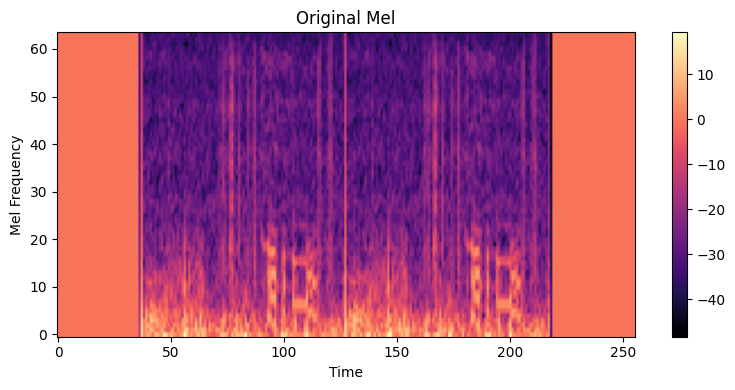

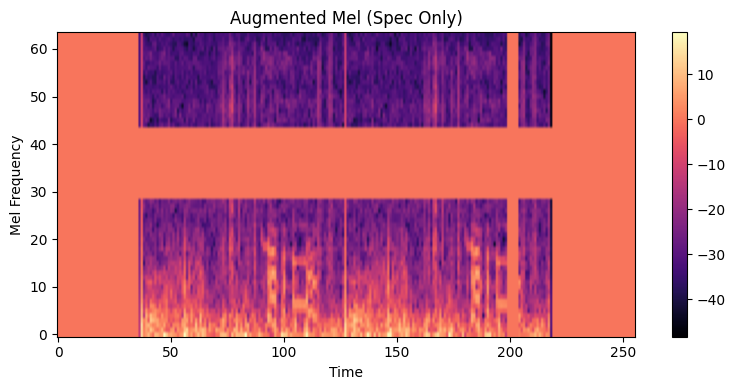

In [20]:
import matplotlib.pyplot as plt

# 데이터 로드
mel = train_dataset[0][0]  # (1, 64, 256)

# 증강 적용
aug_speconly, _ , _ = aug(mel)  # aug1: speconly, aug2: speconly

# 시각화 함수
def show_mel(mel_tensor, title):
    # 텐서 shape이 (1, 64, 256) 또는 (1, 1, 64, 256)일 수 있음
    if mel_tensor.ndim == 4:
        mel_tensor = mel_tensor.squeeze(0)  # (1, 64, 256)
    mel_np = mel_tensor.squeeze(0).cpu().numpy()  # (64, 256)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(mel_np, origin='lower', aspect='auto', cmap='magma')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()

# 시각화
show_mel(mel, "Original Mel")
show_mel(aug_speconly, "Augmented Mel (Spec Only)")


#### 2.4 DataLoader

In [21]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([0., 1.]),
 ('103_2b2_Ar_mc_LittC2SE', np.float64(2.886)))

In [22]:
train_dataset[9][0].shape

torch.Size([1, 64, 256])

In [23]:
# ---------------- 학습 데이터 구성(seed) ----------------
seed_everything(args.seed)

# train_dataset 내에서 각 파일의 인덱스를 추출
pretrain_idx = []
finetune_idx = []

for i in range(len(train_dataset)):
    filename = train_dataset[i][2][0]

    if filename in pretrain_list:
        pretrain_idx.append(i)
    # elif filename in finetune_list:
    #     finetune_idx.append(i)

    # pretrain = finetune
    if filename in finetune_list:
        finetune_idx.append(i)

# 인덱스 순서 셔플
random.shuffle(pretrain_idx)
random.shuffle(finetune_idx)

print(f"Pretrain set size: {len(pretrain_idx)}, Finetune set size: {len(finetune_idx)}")

Pretrain set size: 4142, Finetune set size: 4142


코드 실행 환경에 따라 num_workers를 적절한 값으로 지정해주세요!

In [24]:
# Dataset 생성 (Subset)
pretrain_dataset = Subset(train_dataset, pretrain_idx)
finetune_dataset = Subset(train_dataset, finetune_idx)

# DataLoader 생성
# DataLoader에서 shuffle=True로 지정하면 매 epoch마다 셔플 순서가 달라짐 => 재현성 문제 발생
# pretrain_dataset, finetune_dataset은 이미 셔플이 완료된 것으로, 이것을 DataLoader에 입력함
pretrain_loader = DataLoader(
    pretrain_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    shuffle=False
)

finetune_loader = DataLoader(
    finetune_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    drop_last=True,
    pin_memory=True,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    num_workers=0,
    pin_memory=True,
    shuffle=False
)

label 분포 확인 (단순 참고용, 실제 환경에서는 pretrain set의 label 분포가 어떤지 알 수 없음)

In [25]:
from collections import Counter

# label
labels = torch.stack([multi_label for _, multi_label, _ in train_dataset])

# pretext와 finetune 데이터셋의 라벨 분포 출력
pretrain_labels = labels[pretrain_idx]
pretrain_labels_class = (
    pretrain_labels[:, 0].long() * 1 +  # crackle bit → *1
    pretrain_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}
finetune_labels = labels[finetune_idx]
finetune_labels_class = (
    finetune_labels[:, 0].long() * 1 +  # crackle bit → *1
    finetune_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

# test 데이터셋의 라벨 분포 출력
test_labels = torch.stack([multi_label for _, multi_label, _ in test_dataset])
test_labels_class = (
    test_labels[:, 0].long() * 1 +  # crackle bit → *1
    test_labels[:, 1].long() * 2    # wheeze bit  → *2
)  # [N] shape, values in {0, 1, 2, 3}

print(f"Pretrain sample: {len(pretrain_labels_class)}")
print("Pretrain label distribution:", Counter(pretrain_labels_class.tolist()))
print(f"\nFinetune sample: {len(finetune_labels_class)}")
print("Finetune label distribution:", Counter(finetune_labels_class.tolist()))
print(f"Test sample: {len(test_labels_class)}")
print("Test label distribution:", Counter(test_labels_class.tolist()))

Pretrain sample: 4142
Pretrain label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})

Finetune sample: 4142
Finetune label distribution: Counter({0: 2063, 1: 1215, 2: 501, 3: 363})
Test sample: 2756
Test label distribution: Counter({0: 1579, 1: 649, 2: 385, 3: 143})


## 3. Modeling

#### 3.1 Pre-trained ResNet50

In [26]:
# def backbone_resnet():
#     # 1. 기본 ResNet50 생성 (pretrained=False로 시작)
#     resnet = models.resnet50(pretrained=False)

#     # 2. 첫 번째 conv 레이어를 1채널용으로 수정
#     resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

#     # 먼저 fc 제거
#     resnet.fc = nn.Identity()

#     # 3. ImageNet 가중치 로드 (conv1 제외)
#     state_dict = load_state_dict_from_url(
#         'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#         progress=True
#     )
#     if 'conv1.weight' in state_dict:
#         del state_dict['conv1.weight']
#     resnet.load_state_dict(state_dict, strict=False)

#     return resnet

In [27]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNet50(torchvision.models.resnet.ResNet):
    def __init__(self, track_bn=True):
        def norm_layer(*args, **kwargs):
            return nn.BatchNorm2d(*args, **kwargs, track_running_stats=track_bn)
        super().__init__(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], norm_layer=norm_layer)
        del self.fc
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.final_feat_dim = 2048

    def load_sl_official_weights(self, progress=True):
        weights = ResNet50_Weights.DEFAULT
        state_dict = weights.get_state_dict(progress=progress)

        del state_dict['conv1.weight']
        missing, unexpected = self.load_state_dict(state_dict, strict=False)
        # if len(missing) > 0:
            # raise AssertionError('Model code may be incorrect')

    def load_ssl_official_weights(self, progress=True):
        # only SimCLR is available
        from pl_bolts.models.self_supervised import SimCLR
        
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
        simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)

        state_dict = {}
        for k, v in simclr.state_dict().items():
            if 'encoder.' in k:
                k = k.replace('encoder.', '')
            if 'fc' not in k or 'project' not in k:
                state_dict[k] = v
        missing, unexpected = self.load_state_dict(state_dict, strict=False)
        # non_linear_evaluator.block_forward is a pretrained MLP classifier for SimCLR
        # refer to https://github.com/Lightning-AI/lightning-bolts/blob/bcbbf6ab6c36430946dd8a416ddc7e697e8507fc/pl_bolts/models/self_supervised/evaluator.py#L7
        if len(missing) > 0:
            raise AssertionError('Model code may be incorrect')

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # x = self.fc(x)

        return x

In [28]:
def backbone_resnet50_patch():
    """
    MoCo 구조에 사용할 CNN6 백본 정의 함수.
    
    주요 변경 사항:
    - ResNet50 대신 CNN6 클래스 사용
    - 출력 feature dim은 512로 고정됨 (MoCo에서는 dim_enc=2048 → 이 부분만 맞춰서 사용하면 문제 없음)
    - ImageNet pretrained 사용 대신 공식 CNN6 pretrained 로딩 함수 포함 (옵션 사용 가능)
    """
    model = ResNet50()

    # 공식 SL pretrained weight를 사용하고자 할 경우 아래 줄을 주석 해제
    model.load_sl_official_weights()

    return model


#### 3.2 Pre-trained CNN6

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            

def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)


class ConvBlock5x5(nn.Module): #for CNN6
    def __init__(self, in_channels, out_channels, stride=(1,1)):
        
        super(ConvBlock5x5, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(5, 5), stride=stride,
                              padding=(2, 2), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_bn(self.bn1)
        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x


class CNN6(nn.Module):
    def __init__(self):
        super(CNN6, self).__init__()
        self.final_feat_dim = 512

        self.do_dropout = False
        self.conv_block1 = ConvBlock5x5(in_channels=1, out_channels=64, stride=(1,1))
        self.conv_block2 = ConvBlock5x5(in_channels=64, out_channels=128, stride=(1,1))
        self.conv_block3 = ConvBlock5x5(in_channels=128, out_channels=256, stride=(1,1))
        self.conv_block4 = ConvBlock5x5(in_channels=256, out_channels=512, stride=(1,1))
        self.dropout = nn.Dropout(0.2)
        # self.linear = nn.Linear(512, num_classes, bias=True)

    def load_sl_official_weights(self):
        """ download AudioSet pretrained CNN6 in https://zenodo.org/record/3960586#.Y8dz8y_kEiY
        """
        weights = torch.load('/home/ressera3/boaz/pretrained_pth/Cnn6_mAP=0.343.pth')['model']
        state_dict = {k: v for k, v in weights.items() if k in self.state_dict().keys()}
        missing, unexpected = self.load_state_dict(state_dict, strict=False)

    def forward(self, x, return_feature_map=False):
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        if self.do_dropout:
            x = self.dropout(x)
        
        if return_feature_map:
            return x  # shape: (B, 512, 4, 16)

        x = torch.mean(x, dim=3) #mean over time dim
        (x1, _) = torch.max(x, dim=2) #max over freq dim
        x2 = torch.mean(x, dim=2) #mean over freq dim (after mean over time)
        x = x1 + x2

        # if self.embed_only:
        #     return x
        # return self.linear(x)
        return x

In [30]:
def backbone_cnn6():
    """
    MoCo 구조에 사용할 CNN6 백본 정의 함수.
    
    주요 변경 사항:
    - ResNet50 대신 CNN6 클래스 사용
    - 출력 feature dim은 512로 고정됨 (MoCo에서는 dim_enc=2048 → 이 부분만 맞춰서 사용하면 문제 없음)
    - ImageNet pretrained 사용 대신 공식 CNN6 pretrained 로딩 함수 포함 (옵션 사용 가능)
    """
    model = CNN6()

    # 공식 SL pretrained weight를 사용하고자 할 경우 아래 줄을 주석 해제
    model.load_sl_official_weights()

    return model


##### Multilabel Attention

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MultilabelAttention(nn.Module):
    def __init__(self, backbone, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')]):
        super(MultilabelAttention, self).__init__()
        self.backbone = backbone()
        self.num_classes = num_classes
        self.lambda_attn = lambda_attn
        self.attention_heads = attention_heads  # e.g., [1, inf] for H=2

        self.class_weights = nn.Parameter(torch.randn(len(attention_heads), num_classes, 512))

        self.output_layer = nn.ModuleList([
            nn.Linear(512, 1) for _ in range(num_classes)
        ])

    def forward(self, x):
        # CNN6 백본 통과 → shape: (B, 512, 4, 16)
        feat_map = self.backbone(x, return_feature_map=True)  # (B, 512, 4, 16)

        B, C, Freq, Time = feat_map.shape
        flat_feat = feat_map.view(B, C, Freq * Time).permute(0, 2, 1)  # (B, 64, 512)

        # Class-specific attention a_i 계산
        attn_outputs = []
        for h, T in enumerate(self.attention_heads):
            Ci = self.class_weights[h]  # (num_classes, 512)
            logits = torch.einsum("bnc, kc -> bnk", flat_feat, Ci)  # (B, 64, num_classes)
            logits = logits.permute(0, 2, 1)  # (B, num_classes, 64)
            if T == float('inf'):
                attn_scores = F.one_hot(torch.argmax(logits, dim=2), num_classes=logits.shape[2]).float()
            else:
                attn_scores = F.softmax(T * logits, dim=2)  # (B, num_classes, 64)

            attn_scores = attn_scores.unsqueeze(-1)  # (B, num_classes, 64, 1)
            flat_feat_exp = flat_feat.unsqueeze(1)  # (B, 1, 64, 512)
            attn_feat = torch.sum(attn_scores * flat_feat_exp, dim=2)  # (B, num_classes, 512)
            attn_outputs.append(attn_feat)

        # Class-specific global feature g_i 계산
        feat_avg_t = torch.mean(feat_map, dim=3)  # (B, 512, Freq)
        gmp = torch.max(feat_avg_t, dim=2)[0]     # (B, 512)
        gap = torch.mean(feat_avg_t, dim=2)       # (B, 512)
        g = gmp + gap                             # (B, 512)
        g = g.unsqueeze(1).repeat(1, self.num_classes, 1)  # (B, num_classes, 512)

        # Combine: f_i = g_i + lambda * a_i
        combined = g
        for attn in attn_outputs:
            combined = combined + self.lambda_attn * attn  # sum over heads

        # Output layer for each class
        out = []
        for i in range(self.num_classes):
            cls_feat = combined[:, i, :]  # (B, 512)
            logit = self.output_layer[i](cls_feat).squeeze(-1)  # (B,)
            out.append(logit)

        logits = torch.stack(out, dim=1)  # (B, num_classes)
        probs = torch.sigmoid(logits)    # (B, num_classes)
        return combined, logits, probs                 # 마지막 dim: (B, 2, 512) 


def backbone_mlattention():
    """
    Multi-label attention 기반 backbone 정의 함수
    CNN6 기반 특징 추출기 + CSRA 기반 attention 구조 결합
    
    Returns:
        nn.Module: Multi-label attention 기반 분류기
    """
    return MultilabelAttention(backbone=backbone_cnn6, num_classes=2, lambda_attn=0.5, attention_heads=[1, float('inf')])


In [32]:
x = torch.randn(10, 1, 64, 256) # B=10
model = backbone_mlattention()
out = model(x)  # (B, 2, 512)

print(f"\ntorch.Size : {out.shape}")  # → torch.Size([B=10, 2, 512])

/var/tmp/ipykernel_45178/2561513872.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('/home/ressera3/boaz/pretrained_pth/Cnn6_mAP=0.343.pth')['model

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
# summary 함수 사용: (채널, 높이, 너비) 크기를 지정
summary(backbone_mlattention().to(device), input_size=(1, 64, 256))

/var/tmp/ipykernel_3836/2561513872.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('/home/ressera3/boaz/pretrained_pth/Cnn6_mAP=0.343.pth')['model'

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 256]           1,600
       BatchNorm2d-2          [-1, 64, 64, 256]             128
      ConvBlock5x5-3          [-1, 64, 32, 128]               0
            Conv2d-4         [-1, 128, 32, 128]         204,800
       BatchNorm2d-5         [-1, 128, 32, 128]             256
      ConvBlock5x5-6          [-1, 128, 16, 64]               0
            Conv2d-7          [-1, 256, 16, 64]         819,200
       BatchNorm2d-8          [-1, 256, 16, 64]             512
      ConvBlock5x5-9           [-1, 256, 8, 32]               0
           Conv2d-10           [-1, 512, 8, 32]       3,276,800
      BatchNorm2d-11           [-1, 512, 8, 32]           1,024
     ConvBlock5x5-12           [-1, 512, 4, 16]               0
             CNN6-13           [-1, 512, 4, 16]               0
           Linear-14                   

#### 3.2 MoCo (MLS)

## 4. Training

In [33]:
next(iter(pretrain_loader))[0].shape

torch.Size([128, 1, 64, 256])

In [34]:
def validate(model, val_loader, criterion, device):
    """
    Multi-label (2-hot) → Multi-class (0~3)로 변환하여 평가
    - 입력 shape: inputs [B, C, H, W], labels [B, 2]
    - 출력 shape: preds [N, 2], labels [N, 2]
    - 최종 multi-class 평가: (0=Normal, 1=Crackle, 2=Wheeze, 3=Both)
    """
    import numpy as np

    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            output = model(inputs)
            if isinstance(output, (tuple, list)):  # (ex: (_, output, _))
                output = output[1]
            # output shape: [B, num_classes] (ex. [32, 2])
            # criterion expects same shape
            loss = criterion(output, labels)
            running_loss += loss.item()

            # multi-label prediction (threshold=0.5)
            preds = (torch.sigmoid(output) > 0.5).int()   # [B, 2]
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()   # [N, 2]
    all_labels = torch.cat(all_labels, dim=0).numpy() # [N, 2]

    avg_loss = running_loss / len(val_loader)

    # return shape: (float, [N,2], [N,2])
    return avg_loss, all_labels, all_preds


In [ ]:
import os
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score

train_losses = []
test_losses = []
train_icbhi_scores = []
test_icbhi_scores = []
test_labels_all = []
test_preds_all = []
epochs = []

# 모델 지정하기 전 seed 고정 필요
seed_everything(args.seed) # Seed 고정

# for gam in [2.0,2.3,2.7,3.0]:

pretrain_project_name = f'Raw_MultilabelAtt_T_{args.batch_size}bs_{get_timestamp()}'

# -------------------------------------------wan
# wandb 초기화 (프로젝트명, 실험 이름 등 설정)
wandb.init(
    project="SHS_ATT", # 프로젝트 이름
    name=f"{pretrain_project_name}",  # 실험 이름
    config={
        "epochs": args.epochs,
        "batch_size": args.batch_size,
        "lr": args.lr,
        "momentum": args.momentum,
        "weight_decay": args.weight_decay
    }
)
# -------------------------------------------wan


# 1. MoCo 모델 생성
model = MultilabelAttention(
    backbone=backbone_cnn6, 
    num_classes=2, lambda_attn=0.5, 
    attention_heads=[1, float('inf')]
).cuda()

# model = MultilabelMoCo(
#     base_encoder = backbone_mlattention,
#     dim_enc = 512, # CNN6의 출력 feature dim (default=2048)
#     dim_prj = args.dim_prj,
#     K = args.K,
#     m = args.momentum,
#     T = args.T,
#     top_k = args.top_k,
#     lambda_bce = args.lambda_bce
# ).cuda()

# 2. Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), args.lr, weight_decay=args.weight_decay)
optimizer = torch.optim.Adam(model.parameters(), args.lr) # weight_decay=args.weight_decay

# 3. Cosine Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=1e-6)

# 4. Loss Function
criterion = nn.BCEWithLogitsLoss()

# 5. Train
# Best loss 초기화
best_loss = float('inf')
best_epoch = -1

def multilabel_to_multiclass(y):
    # Crackle → 1, Wheeze → 2, Both → 3, None → 0
    y = np.array(y)
    return y[:, 0] + y[:, 1] * 2

for epoch in range(args.epochs):
    # ===============================
    # Training
    # ===============================
    model.train()
    total_train_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0

    all_preds = []
    all_labels = []
    all_outputs = []

    pbar = tqdm(pretrain_loader, desc='MLATT Trainig only')
    for i, (repeat_mel, label, _) in enumerate(pbar): # label 여기선 사용 X
        img_augonly, _, _ = aug(repeat_mel)
        # 디버깅: 데이터 자체 확인
        img_augonly = img_augonly.cuda(device=args.gpu, non_blocking=True)
        label = label.cuda(args.gpu)

        # backpropagation
        optimizer.zero_grad()
        _ , output, _ = model(img_augonly)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # 예측값과 실제값 저장 ( Ablation(4-1) threshold ?? )
        predicted = (torch.sigmoid(output) > 0.5).float()
        all_preds.append(predicted.detach().cpu())
        all_labels.append(label.detach().cpu())
        all_outputs.append(output.detach().cpu())

    # train loss
    train_loss = total_train_loss / len(pretrain_loader)

    # Concatenate
    all_preds = torch.cat(all_preds, dim=0).numpy()    # shape: [N, 2]
    all_labels = torch.cat(all_labels, dim=0).numpy()  # shape: [N, 2]
    all_output = torch.cat(all_outputs, dim=0).numpy()

    print(f"[Epoch {epoch} | Train Loss: {train_loss:.4f}, img_augonly: {img_augonly.shape}")


    # =====================================
    # 2-Edited. Multi-class 민감도/특이도 계산
    # =====================================
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import wandb
    from sklearn.metrics import confusion_matrix

    def multilabel_to_multiclass(y):
        # Crackle → 1, Wheeze → 2, Both → 3, None → 0
        y = np.array(y)
        return y[:, 0] + y[:, 1]*2

    def evaluate_multiclass_confusion(y_true, y_pred, class_names=["Normal", "Wheeze", "Crackle", "Both"]):
        y_true_cls = multilabel_to_multiclass(y_true)
        y_pred_cls = multilabel_to_multiclass(y_pred)

        cm = confusion_matrix(y_true_cls, y_pred_cls, labels=[0, 1, 2, 3])

        # N_n: 정상 → 정상
        N_n = cm[0, 0]
        N_total = cm[0].sum()

        # 이상 클래스 정답 수: W, C, B
        W_total = cm[1].sum()
        C_total = cm[2].sum()
        B_total = cm[3].sum()

        # 각각의 정답 → 정확한 예측만 고려
        W_w = cm[1, 1]
        C_c = cm[2, 2]
        B_b = cm[3, 3]

        SP = N_n / (N_total + 1e-6) #spec
        SE = (W_w + C_c + B_b) / (W_total + C_total + B_total + 1e-6) #sense

        AS = (SP + SE) / 2
        HS = 2 * SP * SE / (SP + SE + 1e-6)

        return cm, SE, SP, y_true_cls, y_pred_cls

    def log_multiclass_conf_matrix_wandb(cm, class_names, sens, spec, normalize, tag):
        # Normalize (비율) 옵션
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
            fmt = '.2f'
            title = "Confusion Matrix (Normalized %)"
        else:
            fmt = 'd'
            title = "Confusion Matrix (Raw Count)"

        fig, ax = plt.subplots(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=ax)

        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(title)

        icbhi_score = (sens + spec) / 2
        # 우하단에 성능 출력
        ax.text(
            0.99, 0.15,
            f"Sensitivity: {sens*100:.2f}%\nSpecificity: {spec*100:.2f}%\nICBHI Score: {icbhi_score*100:.2f}%",
            ha='right', va='bottom',
            transform=plt.gca().transAxes,
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )

        plt.tight_layout()
        # wandb.log({tag: wandb.Image(fig)})
        # plt.close(fig)
        return fig

    # 1. 4-class Confusion Matrix 평가
    class_names = ["Normal", "Crackle", "Wheeze", "Both"]
    cm_4x4, train_sens, train_spec, y_true_cls, y_pred_cls = evaluate_multiclass_confusion(all_labels, all_preds, class_names)
    icbhi_score = (train_sens + train_spec)/2

    print("4-Class Confusion Matrix:\n", cm_4x4)
    print(f"Sensitivity: {train_sens:.4f}, Specificity: {train_spec:.4f}, ICBHI Score: {icbhi_score:.4f}")


    # ===============================
    # 3. Validation
    # ===============================
    test_loss, test_labels, test_preds = validate(
        model, test_loader, criterion, device
    )

    precision = precision_score(test_labels, test_preds, average='macro')
    recall = recall_score(test_labels, test_preds, average='macro')
    f1 = f1_score(test_labels, test_preds, average='macro')

    test_cm_4x4, test_sens, test_spec, test_y_true_cls, test_y_pred_cls = evaluate_multiclass_confusion(test_labels, test_preds)
    test_icbhi_score = (test_sens+test_spec)/2

    print("[Validation] Confusion Matrix:\n", test_cm_4x4)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"[VALIDATION] Sensitivity: {test_sens:.4f}, Specificity: {test_spec:.4f}, Avg ICBHI Score: {(test_sens+test_spec)/2:.4f}")
    print("##################################################")


    # ===============================
    # 4. Confusion Matrix
    # ===============================

    # 2. Finetune Count Confusion Matrix 시각화
    fig_finetune_raw = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, train_sens, train_spec, normalize=False, tag="Training_conf_matrix_raw")
    fig_finetune_norm = log_multiclass_conf_matrix_wandb(cm_4x4, class_names, train_sens, train_spec, normalize=True, tag="Training_conf_matrix_norm")

    # 3. Test Confusion Matrix 시각화
    fig_test_raw = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=False, tag="test_conf_matrix_raw")
    fig_test_norm = log_multiclass_conf_matrix_wandb(test_cm_4x4, class_names, test_sens, test_spec, normalize=True, tag="test_conf_matrix_norm")

    # 4. log dictionary 생성 -------------------------------------------wan
    wandb_log_dict = {
        "finetune_conf_matrix_raw": wandb.Image(fig_finetune_raw),
        "finetune_conf_matrix_norm": wandb.Image(fig_finetune_norm),
        "test_conf_matrix_raw": wandb.Image(fig_test_raw),
        "test_conf_matrix_norm": wandb.Image(fig_test_norm)
    }
    # -------------------------------------------wan

    # =====================================
    # 5. Checkpoint (Every 100 epochs)
    # =====================================
    if (epoch + 1) % 100 == 0:
        ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_{epoch:03d}.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, ckpt_path)
        print(f"💾 Saved checkpoint to {ckpt_path}")

    # ===============================
    # 6. Save Best Checkpoint
    # ===============================
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        best_ckpt_path = CHECKPOINT_PATH + f"{pretrain_project_name}_best.pth.tar"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss
        }, best_ckpt_path)
        print(f"=> Saved best checkpoint (epoch: {epoch}, loss: {best_loss:.4f})")


        # 🔹 Confusion Matrix Logging for Best
        cm_best, sens_best, spec_best,_, _ = evaluate_multiclass_confusion(test_labels, test_preds, class_names)
        fig_best_raw = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=False, tag="best_test_conf_matrix_raw")

        fig_best_norm = log_multiclass_conf_matrix_wandb(cm_best, class_names, sens_best, spec_best, normalize=True, tag="best_test_conf_matrix_norm")

        # -------------------------------------------wan
        wandb_log_dict.update({
            "best_test_conf_matrix_raw": wandb.Image(fig_best_raw),
            "best_test_conf_matrix_norm": wandb.Image(fig_best_norm)
        })
        # -------------------------------------------wan


    if epoch == args.ft_epochs - 1:
        # 🔸 Confusion Matrix Logging for Last Epoch
        cm_last, sens_last, spec_last, _, _  = evaluate_multiclass_confusion(test_labels, test_preds, class_names)
        fig_last_raw = log_multiclass_conf_matrix_wandb(cm_last, class_names, sens_last, spec_last, normalize=False, tag="last_test_conf_matrix_raw")

        fig_last_norm = log_multiclass_conf_matrix_wandb(cm_last, class_names, sens_last, spec_last, normalize=True, tag="last_test_conf_matrix_norm")

        # -------------------------------------------wan
        wandb_log_dict.update({
            "last_test_conf_matrix_raw": wandb.Image(fig_last_raw),
            "last_test_conf_matrix_norm": wandb.Image(fig_last_norm)
        })
        # -------------------------------------------wan

    # =====================================
    # 7. Logging with wandb confusion matrix
    # =====================================

    # -------------------------------------------wan
    # step 1. metrics
    wandb.log({
        # Train metrics
        "Training/epoch": epoch,
        "Training/train_loss": train_loss,
        "Training/test_loss": test_loss,
        "Training/train_sens": train_sens,
        "Training/train_spec": train_spec,
        "Training/icbhi_score": icbhi_score,

        # Test metrics
        "Test/loss": test_loss,
        "Test/sensitivity": test_sens,
        "Test/specificity": test_spec,
        "Test/icbhi_score": test_icbhi_score
    })

    # step 2. Confusion matrix
    wandb.log(wandb_log_dict)

    # -------------------------------------------wan


    plt.close(fig_finetune_raw)
    plt.close(fig_finetune_norm)
    plt.close(fig_test_raw)
    plt.close(fig_test_norm)
    if 'fig_best_raw' in locals(): plt.close(fig_best_raw)
    if 'fig_best_norm' in locals(): plt.close(fig_best_norm)
    if 'fig_last_raw' in locals(): plt.close(fig_last_raw)
    if 'fig_last_norm' in locals(): plt.close(fig_last_norm)

    # ===============================
    # 8. Scheduler Step
    # ===============================
    scheduler.step()

    # ===============================
    # 9. Save Metrics
    # ===============================
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_icbhi_scores.append(icbhi_score)
    test_icbhi_scores.append(test_icbhi_score)
    epochs.append(epoch)
    # ================================

    # ================================
    # test_labels_all, test_preds_all에 저장
    # ================================
    test_labels_all.append(test_labels)
    test_preds_all.append(test_preds)
    # ================================


# -------------------------------------------wan
wandb.finish()
# -------------------------------------------wan

/var/tmp/ipykernel_45178/2561513872.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('/home/ressera3/boaz/pretrained_pth/Cnn6_mAP=0.343.pth')['model

[Epoch 0 | Train Loss: 0.6067, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1911   90   31   12]
 [1082  101   12    4]
 [ 466   17    7    3]
 [ 337   15    6    2]]
Sensitivity: 0.0536, Specificity: 0.9349, ICBHI Score: 0.4943
[Validation] Confusion Matrix:
 [[1523   52    4    0]
 [ 601   46    2    0]
 [ 381    4    0    0]
 [ 143    0    0    0]]
Test Loss: 0.5176
[VALIDATION] Sensitivity: 0.0391, Specificity: 0.9645, Avg ICBHI Score: 0.5018
##################################################
=> Saved best checkpoint (epoch: 0, loss: 0.5176)


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 1 | Train Loss: 0.5146, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1738  291   14    1]
 [ 722  473    4    0]
 [ 352   39  102    0]
 [ 226   95   39    0]]
Sensitivity: 0.2802, Specificity: 0.8503, ICBHI Score: 0.5653
[Validation] Confusion Matrix:
 [[797 477 303   2]
 [288 337  23   1]
 [141  85 159   0]
 [ 71  37  35   0]]
Test Loss: 0.6422
[VALIDATION] Sensitivity: 0.4214, Specificity: 0.5047, Avg ICBHI Score: 0.4631
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 2 | Train Loss: 0.4736, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1673  322   47    2]
 [ 586  587   25    1]
 [ 228   44  219    2]
 [ 145  111   97    7]]
Sensitivity: 0.3962, Specificity: 0.8185, ICBHI Score: 0.6073
[Validation] Confusion Matrix:
 [[913 399 263   4]
 [350 275  22   2]
 [156  89 131   9]
 [ 57  39  44   3]]
Test Loss: 0.6062
[VALIDATION] Sensitivity: 0.3475, Specificity: 0.5782, Avg ICBHI Score: 0.4629
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 3 | Train Loss: 0.4407, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1665  327   46    6]
 [ 504  678   11    6]
 [ 179   62  233   19]
 [  96  123  106   35]]
Sensitivity: 0.4610, Specificity: 0.8146, ICBHI Score: 0.6378
[Validation] Confusion Matrix:
 [[1012  259  298   10]
 [ 322  288   30    9]
 [ 158   55  153   19]
 [  42   26   61   14]]
Test Loss: 0.6264
[VALIDATION] Sensitivity: 0.3866, Specificity: 0.6409, Avg ICBHI Score: 0.5137
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 4 | Train Loss: 0.4070, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1663  328   48    5]
 [ 513  660   14   12]
 [ 145   37  286   25]
 [  96   92  108   64]]
Sensitivity: 0.4922, Specificity: 0.8136, ICBHI Score: 0.6529
[Validation] Confusion Matrix:
 [[1266  107  204    2]
 [ 490  138   20    1]
 [ 230   34  118    3]
 [  82   17   40    4]]
Test Loss: 0.6051
[VALIDATION] Sensitivity: 0.2209, Specificity: 0.8018, Avg ICBHI Score: 0.5113
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 5 | Train Loss: 0.3998, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1688  308   39    9]
 [ 476  706    6   11]
 [ 153   36  274   30]
 [  87  104   93   76]]
Sensitivity: 0.5146, Specificity: 0.8258, ICBHI Score: 0.6702
[Validation] Confusion Matrix:
 [[1183  156  220   20]
 [ 392  213   35    9]
 [ 164   35  158   28]
 [  45   11   64   23]]
Test Loss: 0.5408
[VALIDATION] Sensitivity: 0.3347, Specificity: 0.7492, Avg ICBHI Score: 0.5420
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s]


[Epoch 6 | Train Loss: 0.3930, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1704  292   37   11]
 [ 453  727    9   10]
 [ 169   41  256   27]
 [  74   96   96   94]]
Sensitivity: 0.5249, Specificity: 0.8337, ICBHI Score: 0.6793
[Validation] Confusion Matrix:
 [[937 161 437  44]
 [312 188  90  59]
 [102  22 224  37]
 [ 22   6  93  22]]
Test Loss: 0.7840
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.5934, Avg ICBHI Score: 0.4811
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


[Epoch 7 | Train Loss: 0.3701, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1706  300   31    7]
 [ 440  738    3   18]
 [ 149   35  269   40]
 [  62   96   79  123]]
Sensitivity: 0.5507, Specificity: 0.8346, ICBHI Score: 0.6927
[Validation] Confusion Matrix:
 [[1120  176  274    9]
 [ 364  245   34    6]
 [ 166   36  160   23]
 [  40   18   66   19]]
Test Loss: 0.6269
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7093, Avg ICBHI Score: 0.5348
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 8 | Train Loss: 0.3691, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1706  297   31   10]
 [ 435  741    6   17]
 [ 155   33  257   48]
 [  55  103   74  128]]
Sensitivity: 0.5487, Specificity: 0.8346, ICBHI Score: 0.6917
[Validation] Confusion Matrix:
 [[1122  116  328   13]
 [ 425  184   36    4]
 [ 154   27  186   18]
 [  52    9   64   18]]
Test Loss: 0.6629
[VALIDATION] Sensitivity: 0.3297, Specificity: 0.7106, Avg ICBHI Score: 0.5201
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 9 | Train Loss: 0.3537, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1731  271   33    9]
 [ 410  767    9   13]
 [ 144   29  275   45]
 [  55   97   69  139]]
Sensitivity: 0.5755, Specificity: 0.8469, ICBHI Score: 0.7112
[Validation] Confusion Matrix:
 [[1144  214  200   21]
 [ 340  274   19   16]
 [ 172   45  121   47]
 [  43   17   46   37]]
Test Loss: 0.5893
[VALIDATION] Sensitivity: 0.3670, Specificity: 0.7245, Avg ICBHI Score: 0.5458
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 10 | Train Loss: 0.3417, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1754  251   28   11]
 [ 376  795    5   23]
 [ 137   28  286   42]
 [  54  100   72  134]]
Sensitivity: 0.5921, Specificity: 0.8581, ICBHI Score: 0.7251
[Validation] Confusion Matrix:
 [[981 287 283  28]
 [282 323  20  24]
 [109  58 158  60]
 [ 29  22  55  37]]
Test Loss: 0.6245
[VALIDATION] Sensitivity: 0.4401, Specificity: 0.6213, Avg ICBHI Score: 0.5307
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[Epoch 11 | Train Loss: 0.3129, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1765  240   30    9]
 [ 326  852    5   16]
 [ 120   28  301   44]
 [  35   88   62  175]]
Sensitivity: 0.6472, Specificity: 0.8635, ICBHI Score: 0.7553
[Validation] Confusion Matrix:
 [[1098  146  326    9]
 [ 364  236   40    9]
 [ 129   41  184   31]
 [  40   10   73   20]]
Test Loss: 0.7546
[VALIDATION] Sensitivity: 0.3738, Specificity: 0.6954, Avg ICBHI Score: 0.5346
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 12 | Train Loss: 0.3075, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1760  238   37    9]
 [ 338  846    5   10]
 [ 132   14  298   49]
 [  33   88   68  171]]
Sensitivity: 0.6408, Specificity: 0.8611, ICBHI Score: 0.7509
[Validation] Confusion Matrix:
 [[1312  118  139   10]
 [ 433  198   14    4]
 [ 219   40  104   22]
 [  63   15   48   17]]
Test Loss: 0.6613
[VALIDATION] Sensitivity: 0.2710, Specificity: 0.8309, Avg ICBHI Score: 0.5510
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 13 | Train Loss: 0.3132, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1749  253   33    9]
 [ 327  851    6   15]
 [ 128   33  285   47]
 [  44   94   59  163]]
Sensitivity: 0.6330, Specificity: 0.8557, ICBHI Score: 0.7444
[Validation] Confusion Matrix:
 [[1244  157  159   19]
 [ 415  214   10   10]
 [ 197   44  119   25]
 [  60   20   45   18]]
Test Loss: 0.5953
[VALIDATION] Sensitivity: 0.2982, Specificity: 0.7878, Avg ICBHI Score: 0.5430
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 14 | Train Loss: 0.2802, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1773  236   27    8]
 [ 298  880    2   19]
 [  95   17  333   48]
 [  39   79   64  178]]
Sensitivity: 0.6779, Specificity: 0.8674, ICBHI Score: 0.7726
[Validation] Confusion Matrix:
 [[1100  251  203   25]
 [ 303  315   16   15]
 [ 148   69  127   41]
 [  40   27   45   31]]
Test Loss: 0.6311
[VALIDATION] Sensitivity: 0.4019, Specificity: 0.6966, Avg ICBHI Score: 0.5493
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 15 | Train Loss: 0.2855, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1783  228   30    3]
 [ 297  876   11   15]
 [  95   23  339   36]
 [  39   86   58  177]]
Sensitivity: 0.6784, Specificity: 0.8723, ICBHI Score: 0.7753
[Validation] Confusion Matrix:
 [[1251  137  175   16]
 [ 419  207   16    7]
 [ 183   43  131   28]
 [  54   14   59   16]]
Test Loss: 0.6689
[VALIDATION] Sensitivity: 0.3008, Specificity: 0.7923, Avg ICBHI Score: 0.5465
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.49it/s]


[Epoch 16 | Train Loss: 0.2828, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1789  224   26    5]
 [ 288  894    3   14]
 [ 121   19  307   46]
 [  43   94   49  174]]
Sensitivity: 0.6701, Specificity: 0.8752, ICBHI Score: 0.7727
[Validation] Confusion Matrix:
 [[1297  155  111   16]
 [ 366  260   16    7]
 [ 215   46  105   19]
 [  55   23   52   13]]
Test Loss: 0.7241
[VALIDATION] Sensitivity: 0.3212, Specificity: 0.8214, Avg ICBHI Score: 0.5713
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 17 | Train Loss: 0.2654, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1811  200   28    5]
 [ 282  895    6   16]
 [  96   19  339   39]
 [  34   87   51  188]]
Sensitivity: 0.6930, Specificity: 0.8860, ICBHI Score: 0.7895
[Validation] Confusion Matrix:
 [[1040  317  195   27]
 [ 277  339   18   15]
 [ 135   84  115   51]
 [  43   28   37   35]]
Test Loss: 0.6926
[VALIDATION] Sensitivity: 0.4155, Specificity: 0.6586, Avg ICBHI Score: 0.5371
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 18 | Train Loss: 0.2884, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1785  225   28    6]
 [ 272  907    4   16]
 [ 120   20  319   34]
 [  40  102   43  175]]
Sensitivity: 0.6827, Specificity: 0.8733, ICBHI Score: 0.7780
[Validation] Confusion Matrix:
 [[1002  320  192   65]
 [ 265  346   12   26]
 [ 124   83  116   62]
 [  31   24   39   49]]
Test Loss: 0.6621
[VALIDATION] Sensitivity: 0.4342, Specificity: 0.6346, Avg ICBHI Score: 0.5344
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 19 | Train Loss: 0.2568, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1826  192   23    3]
 [ 256  925    1   17]
 [  90   24  337   42]
 [  29   83   47  201]]
Sensitivity: 0.7130, Specificity: 0.8933, ICBHI Score: 0.8032
[Validation] Confusion Matrix:
 [[1176  117  263   23]
 [ 382  228   26   13]
 [ 149   38  167   31]
 [  46   12   63   22]]
Test Loss: 0.7341
[VALIDATION] Sensitivity: 0.3543, Specificity: 0.7448, Avg ICBHI Score: 0.5495
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 20 | Train Loss: 0.2236, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1835  181   20    8]
 [ 229  955    3   12]
 [  73   14  369   37]
 [  17   66   44  233]]
Sensitivity: 0.7588, Specificity: 0.8977, ICBHI Score: 0.8283
[Validation] Confusion Matrix:
 [[1223  138  206   12]
 [ 409  214   18    8]
 [ 178   44  142   21]
 [  50   14   61   18]]
Test Loss: 0.7711
[VALIDATION] Sensitivity: 0.3178, Specificity: 0.7745, Avg ICBHI Score: 0.5461
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s]


[Epoch 21 | Train Loss: 0.2659, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1825  196   21    2]
 [ 269  909    7   14]
 [ 108   21  322   42]
 [  38   77   50  195]]
Sensitivity: 0.6949, Specificity: 0.8929, ICBHI Score: 0.7939
[Validation] Confusion Matrix:
 [[1197  181  166   35]
 [ 333  279   23   14]
 [ 164   50  144   27]
 [  45   18   65   15]]
Test Loss: 0.6526
[VALIDATION] Sensitivity: 0.3721, Specificity: 0.7581, Avg ICBHI Score: 0.5651
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


[Epoch 22 | Train Loss: 0.2207, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1854  167   16    7]
 [ 208  968    6   17]
 [  73   15  370   35]
 [  18   79   44  219]]
Sensitivity: 0.7588, Specificity: 0.9070, ICBHI Score: 0.8329
[Validation] Confusion Matrix:
 [[941 376 187  75]
 [213 398  14  24]
 [102  94 129  60]
 [ 39  19  37  48]]
Test Loss: 0.7558
[VALIDATION] Sensitivity: 0.4885, Specificity: 0.5959, Avg ICBHI Score: 0.5422
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 23 | Train Loss: 0.2002, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1864  152   21    7]
 [ 207  977    1   14]
 [  59   12  393   29]
 [  13   58   49  240]]
Sensitivity: 0.7846, Specificity: 0.9119, ICBHI Score: 0.8483
[Validation] Confusion Matrix:
 [[1026  241  266   46]
 [ 277  324   27   21]
 [ 112   55  153   65]
 [  38   13   49   43]]
Test Loss: 0.8277
[VALIDATION] Sensitivity: 0.4418, Specificity: 0.6498, Avg ICBHI Score: 0.5458
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 24 | Train Loss: 0.2108, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1872  154   16    2]
 [ 190  990    3   16]
 [  78   19  354   42]
 [  23   77   38  222]]
Sensitivity: 0.7632, Specificity: 0.9159, ICBHI Score: 0.8395
[Validation] Confusion Matrix:
 [[1141  172  248   18]
 [ 358  246   31   14]
 [ 142   37  165   41]
 [  45   10   69   19]]
Test Loss: 0.7816
[VALIDATION] Sensitivity: 0.3653, Specificity: 0.7226, Avg ICBHI Score: 0.5440
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


[Epoch 25 | Train Loss: 0.1797, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1872  155   14    3]
 [ 192  993    2   12]
 [  70    8  389   26]
 [  15   51   27  267]]
Sensitivity: 0.8036, Specificity: 0.9159, ICBHI Score: 0.8597
[Validation] Confusion Matrix:
 [[1092  347   79   61]
 [ 274  358    5   12]
 [ 156  100   83   46]
 [  50   27   34   32]]
Test Loss: 0.7978
[VALIDATION] Sensitivity: 0.4019, Specificity: 0.6916, Avg ICBHI Score: 0.5467
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


[Epoch 26 | Train Loss: 0.1974, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1874  143   25    2]
 [ 195  986    2   16]
 [  66   18  384   25]
 [  16   79   26  239]]
Sensitivity: 0.7841, Specificity: 0.9168, ICBHI Score: 0.8505
[Validation] Confusion Matrix:
 [[1248  155  146   30]
 [ 365  258   13   13]
 [ 164   59  123   39]
 [  49   19   45   30]]
Test Loss: 0.7944
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7904, Avg ICBHI Score: 0.5698
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 27 | Train Loss: 0.1815, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1884  140   19    1]
 [ 166 1020    2   11]
 [  74   11  373   35]
 [  14   66   29  251]]
Sensitivity: 0.8012, Specificity: 0.9217, ICBHI Score: 0.8614
[Validation] Confusion Matrix:
 [[1149  303   69   58]
 [ 353  279    9    8]
 [ 170   95   76   44]
 [  61   20   33   29]]
Test Loss: 0.8303
[VALIDATION] Sensitivity: 0.3263, Specificity: 0.7277, Avg ICBHI Score: 0.5270
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]


[Epoch 28 | Train Loss: 0.1944, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1883  130   27    4]
 [ 181 1004    2   12]
 [  79   14  373   27]
 [  14   77   27  242]]
Sensitivity: 0.7890, Specificity: 0.9212, ICBHI Score: 0.8551
[Validation] Confusion Matrix:
 [[1152  204  152   71]
 [ 362  231   30   26]
 [ 144   61  127   53]
 [  43   17   47   36]]
Test Loss: 0.8192
[VALIDATION] Sensitivity: 0.3347, Specificity: 0.7296, Avg ICBHI Score: 0.5322
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


[Epoch 29 | Train Loss: 0.1601, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1903  115   18    8]
 [ 159 1031    1    8]
 [  48   11  405   29]
 [   7   70   29  254]]
Sensitivity: 0.8236, Specificity: 0.9310, ICBHI Score: 0.8773
[Validation] Confusion Matrix:
 [[1014  248  274   43]
 [ 342  260   26   21]
 [ 140   40  156   49]
 [  40   16   60   27]]
Test Loss: 0.8900
[VALIDATION] Sensitivity: 0.3764, Specificity: 0.6422, Avg ICBHI Score: 0.5093
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 30 | Train Loss: 0.1947, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1883  131   25    5]
 [ 164 1016    5   14]
 [  79   18  351   45]
 [  21   65   41  233]]
Sensitivity: 0.7797, Specificity: 0.9212, ICBHI Score: 0.8505
[Validation] Confusion Matrix:
 [[1341   96  138    4]
 [ 427  205   10    7]
 [ 240   40   96    9]
 [  77   16   42    8]]
Test Loss: 0.9099
[VALIDATION] Sensitivity: 0.2625, Specificity: 0.8493, Avg ICBHI Score: 0.5559
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 31 | Train Loss: 0.1775, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1882  132   27    3]
 [ 145 1039    0   15]
 [  71   15  386   21]
 [  16   65   35  244]]
Sensitivity: 0.8134, Specificity: 0.9207, ICBHI Score: 0.8670
[Validation] Confusion Matrix:
 [[1155  116  298   10]
 [ 407  213   24    5]
 [ 164   38  166   17]
 [  54   13   53   23]]
Test Loss: 1.0334
[VALIDATION] Sensitivity: 0.3415, Specificity: 0.7315, Avg ICBHI Score: 0.5365
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 32 | Train Loss: 0.1293, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1946   83   15    0]
 [ 102 1087    2    8]
 [  47    4  418   24]
 [  11   45   21  283]]
Sensitivity: 0.8713, Specificity: 0.9521, ICBHI Score: 0.9117
[Validation] Confusion Matrix:
 [[884 416 182  97]
 [205 399  15  30]
 [ 97  82  85 121]
 [ 32  26  17  68]]
Test Loss: 0.9971
[VALIDATION] Sensitivity: 0.4690, Specificity: 0.5598, Avg ICBHI Score: 0.5144
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


[Epoch 33 | Train Loss: 0.1842, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1881  129   27    7]
 [ 185 1000    0   14]
 [  81   10  378   24]
 [  16   68   33  243]]
Sensitivity: 0.7900, Specificity: 0.9203, ICBHI Score: 0.8551
[Validation] Confusion Matrix:
 [[964 251 294  70]
 [271 299  33  46]
 [ 91  54 173  67]
 [ 34  13  46  50]]
Test Loss: 0.9748
[VALIDATION] Sensitivity: 0.4435, Specificity: 0.6105, Avg ICBHI Score: 0.5270
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


[Epoch 34 | Train Loss: 0.1337, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1940   91   13    0]
 [ 106 1080    1   12]
 [  56    7  404   26]
 [   8   47   21  284]]
Sensitivity: 0.8616, Specificity: 0.9491, ICBHI Score: 0.9054
[Validation] Confusion Matrix:
 [[1067  208  240   64]
 [ 335  266   27   21]
 [ 120   53  147   65]
 [  39   20   50   34]]
Test Loss: 0.9313
[VALIDATION] Sensitivity: 0.3798, Specificity: 0.6757, Avg ICBHI Score: 0.5278
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


[Epoch 35 | Train Loss: 0.1144, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1954   75   14    1]
 [  84 1103    1   11]
 [  48    5  412   28]
 [   4   43   16  297]]
Sensitivity: 0.8830, Specificity: 0.9560, ICBHI Score: 0.9195
[Validation] Confusion Matrix:
 [[1145  156  244   34]
 [ 362  253   17   17]
 [ 144   46  144   51]
 [  48   18   49   28]]
Test Loss: 0.9155
[VALIDATION] Sensitivity: 0.3611, Specificity: 0.7251, Avg ICBHI Score: 0.5431
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


[Epoch 36 | Train Loss: 0.1540, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1919   96   23    6]
 [ 127 1054    4   14]
 [  52   12  403   26]
 [  13   60   27  260]]
Sensitivity: 0.8367, Specificity: 0.9388, ICBHI Score: 0.8878
[Validation] Confusion Matrix:
 [[1252  125  167   35]
 [ 420  192   21   16]
 [ 222   24  114   25]
 [  70   12   45   16]]
Test Loss: 1.0089
[VALIDATION] Sensitivity: 0.2736, Specificity: 0.7929, Avg ICBHI Score: 0.5332
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s]


[Epoch 37 | Train Loss: 0.1272, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1941   91   12    0]
 [ 119 1066    1   13]
 [  39    3  423   28]
 [   9   45   19  287]]
Sensitivity: 0.8655, Specificity: 0.9496, ICBHI Score: 0.9076
[Validation] Confusion Matrix:
 [[1044  237  270   28]
 [ 304  302   23   20]
 [ 132   61  141   51]
 [  39   17   56   31]]
Test Loss: 1.0486
[VALIDATION] Sensitivity: 0.4027, Specificity: 0.6612, Avg ICBHI Score: 0.5319
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 38 | Train Loss: 0.1169, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1948   79   15    2]
 [  87 1098    0   14]
 [  37    8  433   15]
 [   7   51   13  289]]
Sensitivity: 0.8869, Specificity: 0.9530, ICBHI Score: 0.9200
[Validation] Confusion Matrix:
 [[1157  282  122   18]
 [ 266  361   10   12]
 [ 176   87   78   44]
 [  50   28   36   29]]
Test Loss: 0.9781
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.7327, Avg ICBHI Score: 0.5652
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


[Epoch 39 | Train Loss: 0.1364, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1928   88   25    3]
 [ 106 1070    3   20]
 [  60    6  411   16]
 [  13   47   24  276]]
Sensitivity: 0.8562, Specificity: 0.9432, ICBHI Score: 0.8997
[Validation] Confusion Matrix:
 [[1129  228  204   18]
 [ 308  313   17   11]
 [ 165   63  121   36]
 [  60   19   41   23]]
Test Loss: 1.0499
[VALIDATION] Sensitivity: 0.3883, Specificity: 0.7150, Avg ICBHI Score: 0.5516
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


[Epoch 40 | Train Loss: 0.1520, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1930   97   15    2]
 [ 137 1048    0   14]
 [  55   14  401   23]
 [  15   58   24  263]]
Sensitivity: 0.8343, Specificity: 0.9442, ICBHI Score: 0.8893
[Validation] Confusion Matrix:
 [[1204  185  171   19]
 [ 364  257   17   11]
 [ 196   47  113   29]
 [  55   17   42   29]]
Test Loss: 1.0185
[VALIDATION] Sensitivity: 0.3390, Specificity: 0.7625, Avg ICBHI Score: 0.5508
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 41 | Train Loss: 0.1425, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1921  101   15    7]
 [  95 1083    4   17]
 [  67   14  392   20]
 [  13   59   17  271]]
Sensitivity: 0.8509, Specificity: 0.9398, ICBHI Score: 0.8954
[Validation] Confusion Matrix:
 [[1233  181  157    8]
 [ 349  274   18    8]
 [ 215   37  115   18]
 [  57   14   53   19]]
Test Loss: 0.9672
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7809, Avg ICBHI Score: 0.5638
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.55it/s]


[Epoch 42 | Train Loss: 0.1265, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1945   76   22    1]
 [ 107 1065    2   25]
 [  57    5  412   19]
 [   6   51   19  284]]
Sensitivity: 0.8582, Specificity: 0.9516, ICBHI Score: 0.9049
[Validation] Confusion Matrix:
 [[1197  206  158   18]
 [ 296  322   16   15]
 [ 181   48  130   26]
 [  53   17   45   28]]
Test Loss: 1.0154
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.7581, Avg ICBHI Score: 0.5829
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s]


[Epoch 43 | Train Loss: 0.1284, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1928   85   25    6]
 [  95 1090    1   13]
 [  66   14  397   16]
 [   8   41   24  287]]
Sensitivity: 0.8645, Specificity: 0.9432, ICBHI Score: 0.9039
[Validation] Confusion Matrix:
 [[964 320 273  22]
 [265 344  20  20]
 [121  61 143  60]
 [ 39  17  57  30]]
Test Loss: 1.0765
[VALIDATION] Sensitivity: 0.4393, Specificity: 0.6105, Avg ICBHI Score: 0.5249
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


[Epoch 44 | Train Loss: 0.1351, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1925   97   22    0]
 [ 114 1068    2   15]
 [  60   11  403   19]
 [   8   47   22  283]]
Sensitivity: 0.8548, Specificity: 0.9418, ICBHI Score: 0.8983
[Validation] Confusion Matrix:
 [[1183  272   99   25]
 [ 327  304   10    8]
 [ 206   67   78   34]
 [  66   24   27   26]]
Test Loss: 0.9784
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7492, Avg ICBHI Score: 0.5479
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 45 | Train Loss: 0.1177, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1963   69   12    0]
 [  93 1095    1   10]
 [  55   12  407   19]
 [  10   44   14  292]]
Sensitivity: 0.8743, Specificity: 0.9604, ICBHI Score: 0.9173
[Validation] Confusion Matrix:
 [[1083  239  229   28]
 [ 324  283   23   19]
 [ 151   49  149   36]
 [  37   16   55   35]]
Test Loss: 1.0914
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6859, Avg ICBHI Score: 0.5413
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 46 | Train Loss: 0.0948, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1965   69   10    0]
 [  79 1103    2   15]
 [  34    4  441   14]
 [   2   26   18  314]]
Sensitivity: 0.9055, Specificity: 0.9614, ICBHI Score: 0.9334
[Validation] Confusion Matrix:
 [[1371  131   70    7]
 [ 428  205   11    5]
 [ 245   40   85   15]
 [  63   15   42   23]]
Test Loss: 1.0271
[VALIDATION] Sensitivity: 0.2659, Specificity: 0.8683, Avg ICBHI Score: 0.5671
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[Epoch 47 | Train Loss: 0.1155, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1962   69   10    3]
 [  90 1094    1   14]
 [  57    4  421   11]
 [   8   49   13  290]]
Sensitivity: 0.8796, Specificity: 0.9599, ICBHI Score: 0.9198
[Validation] Confusion Matrix:
 [[1220  203  137   19]
 [ 369  257   11   12]
 [ 192   64  101   28]
 [  62   19   38   24]]
Test Loss: 1.0773
[VALIDATION] Sensitivity: 0.3246, Specificity: 0.7726, Avg ICBHI Score: 0.5486
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 48 | Train Loss: 0.1115, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1946   81   13    4]
 [  82 1105    1   11]
 [  71    3  409   10]
 [   9   39   18  294]]
Sensitivity: 0.8811, Specificity: 0.9521, ICBHI Score: 0.9166
[Validation] Confusion Matrix:
 [[986 391 149  53]
 [228 395  10  16]
 [140  89  93  63]
 [ 40  33  26  44]]
Test Loss: 1.1021
[VALIDATION] Sensitivity: 0.4520, Specificity: 0.6244, Avg ICBHI Score: 0.5382
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 49 | Train Loss: 0.0858, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1991   38   14    1]
 [  78 1109    3    9]
 [  37    4  438   14]
 [   2   29   16  313]]
Sensitivity: 0.9064, Specificity: 0.9741, ICBHI Score: 0.9403
[Validation] Confusion Matrix:
 [[1080  264  198   37]
 [ 316  305   16   12]
 [ 159   50  126   50]
 [  47   16   53   27]]
Test Loss: 1.0052
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6840, Avg ICBHI Score: 0.5366
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 50 | Train Loss: 0.1001, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1952   82   10    0]
 [  81 1109    0    9]
 [  36    8  430   19]
 [   6   44   12  298]]
Sensitivity: 0.8952, Specificity: 0.9550, ICBHI Score: 0.9251
[Validation] Confusion Matrix:
 [[1252  135  153   39]
 [ 416  206   14   13]
 [ 193   34  117   41]
 [  55   18   40   30]]
Test Loss: 1.0876
[VALIDATION] Sensitivity: 0.2999, Specificity: 0.7929, Avg ICBHI Score: 0.5464
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 51 | Train Loss: 0.1358, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1934   85   22    3]
 [ 105 1071    3   20]
 [  72    5  391   25]
 [  11   48   20  281]]
Sensitivity: 0.8494, Specificity: 0.9462, ICBHI Score: 0.8978
[Validation] Confusion Matrix:
 [[1246  220   89   24]
 [ 402  232    6    9]
 [ 221   68   71   25]
 [  70   24   29   20]]
Test Loss: 1.0750
[VALIDATION] Sensitivity: 0.2744, Specificity: 0.7891, Avg ICBHI Score: 0.5318
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 52 | Train Loss: 0.0898, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1973   56   14    1]
 [  65 1122    2   10]
 [  40    6  436   11]
 [   4   41   12  303]]
Sensitivity: 0.9069, Specificity: 0.9653, ICBHI Score: 0.9361
[Validation] Confusion Matrix:
 [[1076  305  171   27]
 [ 280  334   15   20]
 [ 160   76   92   57]
 [  42   20   40   41]]
Test Loss: 1.1074
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6814, Avg ICBHI Score: 0.5391
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 53 | Train Loss: 0.1029, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1974   49   17    4]
 [  89 1095    2   13]
 [  43    6  431   13]
 [   6   29   18  307]]
Sensitivity: 0.8933, Specificity: 0.9658, ICBHI Score: 0.9295
[Validation] Confusion Matrix:
 [[1052  339  171   17]
 [ 264  360   11   14]
 [ 176   78   92   39]
 [  63   25   34   21]]
Test Loss: 1.1338
[VALIDATION] Sensitivity: 0.4019, Specificity: 0.6662, Avg ICBHI Score: 0.5341
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 54 | Train Loss: 0.0969, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1947   82   12    3]
 [  80 1111    1    7]
 [  38    3  440   12]
 [   8   32   10  310]]
Sensitivity: 0.9069, Specificity: 0.9525, ICBHI Score: 0.9297
[Validation] Confusion Matrix:
 [[1173  225  145   36]
 [ 335  280   16   18]
 [ 191   46  115   33]
 [  52   17   47   27]]
Test Loss: 0.9894
[VALIDATION] Sensitivity: 0.3585, Specificity: 0.7429, Avg ICBHI Score: 0.5507
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 55 | Train Loss: 0.1010, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1968   57   16    3]
 [  68 1121    3    7]
 [  47    5  430   11]
 [   5   39   22  294]]
Sensitivity: 0.8991, Specificity: 0.9628, ICBHI Score: 0.9310
[Validation] Confusion Matrix:
 [[1144  319   95   21]
 [ 267  356   13   13]
 [ 168   92   84   41]
 [  54   26   35   28]]
Test Loss: 0.9882
[VALIDATION] Sensitivity: 0.3976, Specificity: 0.7245, Avg ICBHI Score: 0.5611
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 56 | Train Loss: 0.1004, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1963   65   15    1]
 [  75 1112    2   10]
 [  47    5  428   13]
 [   6   38   14  302]]
Sensitivity: 0.8977, Specificity: 0.9604, ICBHI Score: 0.9290
[Validation] Confusion Matrix:
 [[1010  481   45   43]
 [ 268  364    5   12]
 [ 157  141   50   37]
 [  49   47   16   31]]
Test Loss: 1.1925
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6396, Avg ICBHI Score: 0.5089
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 57 | Train Loss: 0.1081, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1964   64   14    2]
 [  71 1110    2   16]
 [  55    9  418   11]
 [   5   45    9  301]]
Sensitivity: 0.8913, Specificity: 0.9609, ICBHI Score: 0.9261
[Validation] Confusion Matrix:
 [[1197  278   88   16]
 [ 303  329    6   11]
 [ 193   89   68   35]
 [  64   22   35   22]]
Test Loss: 1.0529
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7581, Avg ICBHI Score: 0.5570
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 58 | Train Loss: 0.0709, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1982   48   13    1]
 [  55 1136    1    7]
 [  33    1  452    7]
 [   6   19    8  327]]
Sensitivity: 0.9332, Specificity: 0.9697, ICBHI Score: 0.9515
[Validation] Confusion Matrix:
 [[957 476  75  71]
 [235 398   1  15]
 [149 125  53  58]
 [ 42  41  20  40]]
Test Loss: 1.2101
[VALIDATION] Sensitivity: 0.4172, Specificity: 0.6061, Avg ICBHI Score: 0.5116
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 59 | Train Loss: 0.0799, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1978   51   15    0]
 [  48 1139    3    9]
 [  44    1  436   12]
 [   3   30   14  313]]
Sensitivity: 0.9201, Specificity: 0.9677, ICBHI Score: 0.9439
[Validation] Confusion Matrix:
 [[1136  199  216   28]
 [ 390  227   19   13]
 [ 181   43  135   26]
 [  55   13   52   23]]
Test Loss: 1.1586
[VALIDATION] Sensitivity: 0.3271, Specificity: 0.7194, Avg ICBHI Score: 0.5233
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[Epoch 60 | Train Loss: 0.0799, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1987   47    8    2]
 [  53 1138    0    8]
 [  41    4  437   11]
 [   3   24   13  320]]
Sensitivity: 0.9235, Specificity: 0.9721, ICBHI Score: 0.9478
[Validation] Confusion Matrix:
 [[1228  208  133   10]
 [ 351  281   11    6]
 [ 201   60   99   25]
 [  65   21   39   18]]
Test Loss: 1.1288
[VALIDATION] Sensitivity: 0.3381, Specificity: 0.7777, Avg ICBHI Score: 0.5579
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 61 | Train Loss: 0.0606, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1996   35   11    2]
 [  44 1147    2    6]
 [  21    0  463    9]
 [   4   22    8  326]]
Sensitivity: 0.9435, Specificity: 0.9765, ICBHI Score: 0.9600
[Validation] Confusion Matrix:
 [[1065  284  186   44]
 [ 335  273   20   21]
 [ 155   71  104   55]
 [  38   24   54   27]]
Test Loss: 1.1916
[VALIDATION] Sensitivity: 0.3432, Specificity: 0.6745, Avg ICBHI Score: 0.5089
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 62 | Train Loss: 0.0768, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1982   49   13    0]
 [  60 1121    1   17]
 [  35    6  440   12]
 [   7   28    9  316]]
Sensitivity: 0.9147, Specificity: 0.9697, ICBHI Score: 0.9422
[Validation] Confusion Matrix:
 [[1031  346  166   36]
 [ 259  369    7   14]
 [ 135   88  104   58]
 [  52   28   34   29]]
Test Loss: 1.1372
[VALIDATION] Sensitivity: 0.4265, Specificity: 0.6529, Avg ICBHI Score: 0.5397
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 63 | Train Loss: 0.0682, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1990   42   12    0]
 [  56 1135    2    6]
 [  24    3  458    8]
 [   1   24   12  323]]
Sensitivity: 0.9337, Specificity: 0.9736, ICBHI Score: 0.9537
[Validation] Confusion Matrix:
 [[1064  278  177   60]
 [ 332  291   10   16]
 [ 142   86   88   69]
 [  55   34   25   29]]
Test Loss: 1.2313
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.6738, Avg ICBHI Score: 0.5102
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[Epoch 64 | Train Loss: 0.0785, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1983   42   19    0]
 [  57 1134    1    7]
 [  42    3  435   13]
 [   4   22   12  322]]
Sensitivity: 0.9215, Specificity: 0.9702, ICBHI Score: 0.9458
[Validation] Confusion Matrix:
 [[1021  304  229   25]
 [ 294  322   16   17]
 [ 148   69  126   42]
 [  44   27   41   31]]
Test Loss: 1.2490
[VALIDATION] Sensitivity: 0.4070, Specificity: 0.6466, Avg ICBHI Score: 0.5268
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 65 | Train Loss: 0.0941, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1961   71   12    0]
 [  86 1101    1   11]
 [  35    3  438   17]
 [   6   33   15  306]]
Sensitivity: 0.8991, Specificity: 0.9594, ICBHI Score: 0.9293
[Validation] Confusion Matrix:
 [[1162  215  200    2]
 [ 361  266   17    5]
 [ 186   49  118   32]
 [  63   16   50   14]]
Test Loss: 1.3249
[VALIDATION] Sensitivity: 0.3381, Specificity: 0.7359, Avg ICBHI Score: 0.5370
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 66 | Train Loss: 0.0787, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1971   59   11    3]
 [  50 1138    2    9]
 [  45    2  437    9]
 [   5   25   11  319]]
Sensitivity: 0.9230, Specificity: 0.9643, ICBHI Score: 0.9436
[Validation] Confusion Matrix:
 [[1189  198  180   12]
 [ 380  245   12   12]
 [ 182   66   94   43]
 [  58   23   40   22]]
Test Loss: 1.2239
[VALIDATION] Sensitivity: 0.3067, Specificity: 0.7530, Avg ICBHI Score: 0.5299
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 67 | Train Loss: 0.0593, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1995   38   11    0]
 [  37 1155    1    6]
 [  25    1  462    5]
 [   3   20   12  325]]
Sensitivity: 0.9464, Specificity: 0.9760, ICBHI Score: 0.9612
[Validation] Confusion Matrix:
 [[957 385 202  35]
 [242 377  11  19]
 [132  78 117  58]
 [ 39  30  40  34]]
Test Loss: 1.1699
[VALIDATION] Sensitivity: 0.4486, Specificity: 0.6061, Avg ICBHI Score: 0.5273
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 68 | Train Loss: 0.0674, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2002   38    4    0]
 [  43 1143    2   11]
 [  36    5  440   12]
 [   2   28   12  318]]
Sensitivity: 0.9264, Specificity: 0.9795, ICBHI Score: 0.9529
[Validation] Confusion Matrix:
 [[1166  246  131   36]
 [ 344  278   11   16]
 [ 171   74   82   58]
 [  50   26   33   34]]
Test Loss: 1.1928
[VALIDATION] Sensitivity: 0.3347, Specificity: 0.7384, Avg ICBHI Score: 0.5366
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 69 | Train Loss: 0.0744, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1991   36   14    3]
 [  54 1137    1    7]
 [  35    5  440   13]
 [   4   25   11  320]]
Sensitivity: 0.9245, Specificity: 0.9741, ICBHI Score: 0.9493
[Validation] Confusion Matrix:
 [[1118  238  208   15]
 [ 357  263   18   11]
 [ 178   43  127   37]
 [  59   16   49   19]]
Test Loss: 1.2688
[VALIDATION] Sensitivity: 0.3475, Specificity: 0.7080, Avg ICBHI Score: 0.5278
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 70 | Train Loss: 0.0531, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2006   25   13    0]
 [  33 1158    0    8]
 [  22    3  457   11]
 [   2   21    4  333]]
Sensitivity: 0.9493, Specificity: 0.9814, ICBHI Score: 0.9654
[Validation] Confusion Matrix:
 [[957 324 253  45]
 [261 338  22  28]
 [110  72 129  74]
 [ 38  24  40  41]]
Test Loss: 1.2562
[VALIDATION] Sensitivity: 0.4316, Specificity: 0.6061, Avg ICBHI Score: 0.5188
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 71 | Train Loss: 0.0468, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2010   26    7    1]
 [  34 1155    0   10]
 [  21    2  465    5]
 [   1   17    4  338]]
Sensitivity: 0.9542, Specificity: 0.9834, ICBHI Score: 0.9688
[Validation] Confusion Matrix:
 [[1026  332  195   26]
 [ 260  364   13   12]
 [ 155   70  111   49]
 [  47   26   42   28]]
Test Loss: 1.1885
[VALIDATION] Sensitivity: 0.4274, Specificity: 0.6498, Avg ICBHI Score: 0.5386
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 72 | Train Loss: 0.0648, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2000   29   14    1]
 [  37 1152    0   10]
 [  35    2  445   11]
 [   5   20   12  323]]
Sensitivity: 0.9357, Specificity: 0.9785, ICBHI Score: 0.9571
[Validation] Confusion Matrix:
 [[1181  183  194   21]
 [ 379  243   18    9]
 [ 177   47  130   31]
 [  59   19   49   16]]
Test Loss: 1.3970
[VALIDATION] Sensitivity: 0.3305, Specificity: 0.7479, Avg ICBHI Score: 0.5392
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 73 | Train Loss: 0.0673, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1996   35   13    0]
 [  52 1138    1    8]
 [  32    4  451    6]
 [   6   23   13  318]]
Sensitivity: 0.9293, Specificity: 0.9765, ICBHI Score: 0.9529
[Validation] Confusion Matrix:
 [[962 447 111  59]
 [237 387   6  19]
 [125 117  74  69]
 [ 42  35  31  35]]
Test Loss: 1.3372
[VALIDATION] Sensitivity: 0.4214, Specificity: 0.6092, Avg ICBHI Score: 0.5153
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 74 | Train Loss: 0.0693, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1983   55    4    2]
 [  48 1144    1    6]
 [  15    7  453   18]
 [   2   23   18  317]]
Sensitivity: 0.9327, Specificity: 0.9702, ICBHI Score: 0.9515
[Validation] Confusion Matrix:
 [[1250  171  145   13]
 [ 359  268   11   11]
 [ 208   35  121   21]
 [  64   17   44   18]]
Test Loss: 1.1912
[VALIDATION] Sensitivity: 0.3458, Specificity: 0.7916, Avg ICBHI Score: 0.5687
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 75 | Train Loss: 0.0902, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1979   48   16    1]
 [  83 1106    2    8]
 [  45    6  425   17]
 [   8   26   15  311]]
Sensitivity: 0.8977, Specificity: 0.9682, ICBHI Score: 0.9329
[Validation] Confusion Matrix:
 [[1058  235  247   39]
 [ 315  293   18   23]
 [ 133   62  123   67]
 [  42   19   54   28]]
Test Loss: 1.3824
[VALIDATION] Sensitivity: 0.3772, Specificity: 0.6700, Avg ICBHI Score: 0.5236
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 76 | Train Loss: 0.0777, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1986   41   17    0]
 [  63 1125    2    9]
 [  41   10  433    9]
 [   6   18   13  323]]
Sensitivity: 0.9167, Specificity: 0.9716, ICBHI Score: 0.9441
[Validation] Confusion Matrix:
 [[1107  284  163   25]
 [ 317  301   12   19]
 [ 157   64  107   57]
 [  48   22   44   29]]
Test Loss: 1.2062
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.7011, Avg ICBHI Score: 0.5362
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 77 | Train Loss: 0.0605, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2004   31    9    0]
 [  40 1153    1    5]
 [  25    4  459    5]
 [   3   21   10  326]]
Sensitivity: 0.9444, Specificity: 0.9804, ICBHI Score: 0.9624
[Validation] Confusion Matrix:
 [[1172  207  179   21]
 [ 373  241   20   15]
 [ 174   45  124   42]
 [  54   16   55   18]]
Test Loss: 1.2539
[VALIDATION] Sensitivity: 0.3254, Specificity: 0.7422, Avg ICBHI Score: 0.5338
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 78 | Train Loss: 0.0424, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2012   22    8    2]
 [  24 1170    0    5]
 [  24    1  467    1]
 [   0   22    3  335]]
Sensitivity: 0.9610, Specificity: 0.9843, ICBHI Score: 0.9727
[Validation] Confusion Matrix:
 [[997 321 213  48]
 [266 345  15  23]
 [122  70 117  76]
 [ 37  22  43  41]]
Test Loss: 1.3100
[VALIDATION] Sensitivity: 0.4274, Specificity: 0.6314, Avg ICBHI Score: 0.5294
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 79 | Train Loss: 0.0533, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2002   32    9    1]
 [  37 1152    2    8]
 [  26    3  458    6]
 [   2   15    9  334]]
Sensitivity: 0.9474, Specificity: 0.9795, ICBHI Score: 0.9634
[Validation] Confusion Matrix:
 [[920 371 247  41]
 [265 345  17  22]
 [118  73 126  68]
 [ 41  27  35  40]]
Test Loss: 1.4802
[VALIDATION] Sensitivity: 0.4342, Specificity: 0.5826, Avg ICBHI Score: 0.5084
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


[Epoch 80 | Train Loss: 0.0519, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1998   37    9    0]
 [  30 1155    1   13]
 [  25    2  457    9]
 [   1   18    5  336]]
Sensitivity: 0.9493, Specificity: 0.9775, ICBHI Score: 0.9634
[Validation] Confusion Matrix:
 [[1217  167  181   14]
 [ 379  241   17   12]
 [ 190   28  137   30]
 [  59   15   53   16]]
Test Loss: 1.2658
[VALIDATION] Sensitivity: 0.3347, Specificity: 0.7707, Avg ICBHI Score: 0.5527
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


[Epoch 81 | Train Loss: 0.0688, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1986   50    8    0]
 [  50 1142    1    6]
 [  35    5  441   12]
 [   7   16   18  319]]
Sensitivity: 0.9269, Specificity: 0.9716, ICBHI Score: 0.9493
[Validation] Confusion Matrix:
 [[1058  287  204   30]
 [ 301  315   15   18]
 [ 146   61  124   54]
 [  47   23   45   28]]
Test Loss: 1.2308
[VALIDATION] Sensitivity: 0.3968, Specificity: 0.6700, Avg ICBHI Score: 0.5334
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s]


[Epoch 82 | Train Loss: 0.0630, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1987   33   21    3]
 [  48 1142    1    8]
 [  30    4  454    5]
 [   2   24    9  325]]
Sensitivity: 0.9362, Specificity: 0.9721, ICBHI Score: 0.9541
[Validation] Confusion Matrix:
 [[1236  199  133   11]
 [ 373  252   16    8]
 [ 206   40  109   30]
 [  64   14   49   16]]
Test Loss: 1.1496
[VALIDATION] Sensitivity: 0.3203, Specificity: 0.7828, Avg ICBHI Score: 0.5515
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 83 | Train Loss: 0.0349, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2029   11    4    0]
 [  20 1176    0    3]
 [  14    2  472    5]
 [   2    9   11  338]]
Sensitivity: 0.9678, Specificity: 0.9927, ICBHI Score: 0.9802
[Validation] Confusion Matrix:
 [[942 329 266  42]
 [278 321  26  24]
 [115  51 143  76]
 [ 27  15  63  38]]
Test Loss: 1.3776
[VALIDATION] Sensitivity: 0.4265, Specificity: 0.5966, Avg ICBHI Score: 0.5115
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 84 | Train Loss: 0.0620, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1988   39   14    3]
 [  43 1148    0    8]
 [  29    4  455    5]
 [   4   25    5  326]]
Sensitivity: 0.9401, Specificity: 0.9726, ICBHI Score: 0.9563
[Validation] Confusion Matrix:
 [[1038  201  314   26]
 [ 342  253   32   22]
 [ 122   39  175   49]
 [  45   14   62   22]]
Test Loss: 1.3716
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.6574, Avg ICBHI Score: 0.5199
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 85 | Train Loss: 0.0476, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2012   25    7    0]
 [  31 1163    2    3]
 [  22    4  462    5]
 [   3   18    7  332]]
Sensitivity: 0.9537, Specificity: 0.9843, ICBHI Score: 0.9690
[Validation] Confusion Matrix:
 [[925 363 256  35]
 [258 348  17  26]
 [103  75 135  72]
 [ 34  27  42  40]]
Test Loss: 1.3883
[VALIDATION] Sensitivity: 0.4444, Specificity: 0.5858, Avg ICBHI Score: 0.5151
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 86 | Train Loss: 0.0474, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2005   29   10    0]
 [  38 1157    0    4]
 [  19    1  466    7]
 [   2   11    9  338]]
Sensitivity: 0.9557, Specificity: 0.9809, ICBHI Score: 0.9683
[Validation] Confusion Matrix:
 [[1071  252  240   16]
 [ 347  268   20   14]
 [ 151   52  145   37]
 [  50   19   53   21]]
Test Loss: 1.4201
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.6783, Avg ICBHI Score: 0.5235
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 87 | Train Loss: 0.0513, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2006   27   11    0]
 [  38 1155    2    4]
 [  27    0  459    7]
 [   6   18    8  328]]
Sensitivity: 0.9464, Specificity: 0.9814, ICBHI Score: 0.9639
[Validation] Confusion Matrix:
 [[1099  306  160   14]
 [ 295  324   12   18]
 [ 154   77  107   47]
 [  50   17   45   31]]
Test Loss: 1.3341
[VALIDATION] Sensitivity: 0.3925, Specificity: 0.6960, Avg ICBHI Score: 0.5443
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[Epoch 88 | Train Loss: 0.0576, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1991   46    4    3]
 [  46 1138    2   13]
 [  25    2  457    9]
 [   4   12   10  334]]
Sensitivity: 0.9401, Specificity: 0.9741, ICBHI Score: 0.9571
[Validation] Confusion Matrix:
 [[883 385 290  21]
 [218 376  25  30]
 [ 97  68 160  60]
 [ 30  24  54  35]]
Test Loss: 1.3357
[VALIDATION] Sensitivity: 0.4851, Specificity: 0.5592, Avg ICBHI Score: 0.5222
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 89 | Train Loss: 0.0498, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1992   39   12    1]
 [  29 1165    1    4]
 [  21    1  467    4]
 [   2   18    7  333]]
Sensitivity: 0.9576, Specificity: 0.9746, ICBHI Score: 0.9661
[Validation] Confusion Matrix:
 [[1103  291  158   27]
 [ 299  313   20   17]
 [ 152   74  106   53]
 [  42   22   49   30]]
Test Loss: 1.2287
[VALIDATION] Sensitivity: 0.3815, Specificity: 0.6985, Avg ICBHI Score: 0.5400
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s]


[Epoch 90 | Train Loss: 0.0447, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2009   28    6    1]
 [  36 1156    1    6]
 [  20    2  469    2]
 [   1   10    3  346]]
Sensitivity: 0.9605, Specificity: 0.9829, ICBHI Score: 0.9717
[Validation] Confusion Matrix:
 [[1059  325  168   27]
 [ 312  312   11   14]
 [ 156   85   96   48]
 [  50   20   42   31]]
Test Loss: 1.3399
[VALIDATION] Sensitivity: 0.3730, Specificity: 0.6707, Avg ICBHI Score: 0.5218
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 91 | Train Loss: 0.0498, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2010   20   14    0]
 [  28 1160    2    9]
 [  25    3  460    5]
 [   4   21    6  329]]
Sensitivity: 0.9498, Specificity: 0.9834, ICBHI Score: 0.9666
[Validation] Confusion Matrix:
 [[1007  373  165   34]
 [ 243  381   13   12]
 [ 135   88   93   69]
 [  42   38   27   36]]
Test Loss: 1.2705
[VALIDATION] Sensitivity: 0.4333, Specificity: 0.6377, Avg ICBHI Score: 0.5355
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 92 | Train Loss: 0.0250, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2027   13    4    0]
 [   9 1186    1    3]
 [  11    0  480    2]
 [   0    8    1  351]]
Sensitivity: 0.9829, Specificity: 0.9917, ICBHI Score: 0.9873
[Validation] Confusion Matrix:
 [[1032  262  253   32]
 [ 307  303   20   19]
 [ 124   55  144   62]
 [  41   16   53   33]]
Test Loss: 1.3924
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.6536, Avg ICBHI Score: 0.5307
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 93 | Train Loss: 0.0452, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2004   30    9    1]
 [  30 1160    0    9]
 [  24    1  465    3]
 [   4   13    3  340]]
Sensitivity: 0.9576, Specificity: 0.9804, ICBHI Score: 0.9690
[Validation] Confusion Matrix:
 [[1164  185  201   29]
 [ 346  259   29   15]
 [ 147   41  141   56]
 [  43   14   60   26]]
Test Loss: 1.3481
[VALIDATION] Sensitivity: 0.3619, Specificity: 0.7372, Avg ICBHI Score: 0.5496
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]


[Epoch 94 | Train Loss: 0.0668, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1997   38    8    1]
 [  43 1146    0   10]
 [  33    6  445    9]
 [   2   25   16  317]]
Sensitivity: 0.9298, Specificity: 0.9770, ICBHI Score: 0.9534
[Validation] Confusion Matrix:
 [[906 396 229  48]
 [213 387  23  26]
 [ 99  89 120  77]
 [ 36  31  32  44]]
Test Loss: 1.4010
[VALIDATION] Sensitivity: 0.4681, Specificity: 0.5738, Avg ICBHI Score: 0.5210
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 95 | Train Loss: 0.0333, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2026   16    2    0]
 [  24 1171    1    3]
 [   9    0  478    6]
 [   3   15    1  341]]
Sensitivity: 0.9698, Specificity: 0.9912, ICBHI Score: 0.9805
[Validation] Confusion Matrix:
 [[910 449 175  45]
 [214 395  18  22]
 [114  92  98  81]
 [ 36  27  27  53]]
Test Loss: 1.3962
[VALIDATION] Sensitivity: 0.4639, Specificity: 0.5763, Avg ICBHI Score: 0.5201
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]


[Epoch 96 | Train Loss: 0.0581, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1999   28   16    1]
 [  42 1147    0   10]
 [  39    3  441   10]
 [   0   20    8  332]]
Sensitivity: 0.9357, Specificity: 0.9780, ICBHI Score: 0.9568
[Validation] Confusion Matrix:
 [[1021  319  222   17]
 [ 277  337   13   22]
 [ 133   62  129   61]
 [  42   23   44   34]]
Test Loss: 1.3312
[VALIDATION] Sensitivity: 0.4248, Specificity: 0.6466, Avg ICBHI Score: 0.5357
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


[Epoch 97 | Train Loss: 0.0379, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2014   20    7    3]
 [  21 1173    1    4]
 [  20    2  468    3]
 [   2    7    8  343]]
Sensitivity: 0.9669, Specificity: 0.9853, ICBHI Score: 0.9761
[Validation] Confusion Matrix:
 [[919 412 232  16]
 [231 384  18  16]
 [121  77 120  67]
 [ 39  27  34  43]]
Test Loss: 1.4835
[VALIDATION] Sensitivity: 0.4647, Specificity: 0.5820, Avg ICBHI Score: 0.5234
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 98 | Train Loss: 0.0412, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2014   26    4    0]
 [  27 1168    0    4]
 [  18    1  468    6]
 [   1   13   10  336]]
Sensitivity: 0.9610, Specificity: 0.9853, ICBHI Score: 0.9732
[Validation] Confusion Matrix:
 [[1181  261  127   10]
 [ 341  283   14   11]
 [ 183   60   98   44]
 [  56   22   44   21]]
Test Loss: 1.3370
[VALIDATION] Sensitivity: 0.3415, Specificity: 0.7479, Avg ICBHI Score: 0.5447
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


[Epoch 99 | Train Loss: 0.0296, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2023   16    5    0]
 [  21 1173    0    5]
 [   6    1  480    6]
 [   1   16    6  337]]
Sensitivity: 0.9698, Specificity: 0.9897, ICBHI Score: 0.9798
[Validation] Confusion Matrix:
 [[1033  264  258   24]
 [ 298  307   22   22]
 [ 119   61  144   61]
 [  40   22   48   33]]
Test Loss: 1.3546
[VALIDATION] Sensitivity: 0.4112, Specificity: 0.6542, Avg ICBHI Score: 0.5327
##################################################
💾 Saved checkpoint to /home/ressera3/BOAZ-Chungzins/notebook/0721note_ckp/Raw_MultilabelAtt_T_128bs_2507210335_099.pth.tar


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


[Epoch 100 | Train Loss: 0.0531, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2000   27   17    0]
 [  31 1158    6    4]
 [  31    4  451    7]
 [   5   16   10  329]]
Sensitivity: 0.9444, Specificity: 0.9785, ICBHI Score: 0.9615
[Validation] Confusion Matrix:
 [[1158  246  163   12]
 [ 328  290   21   10]
 [ 172   56  113   44]
 [  57   17   43   26]]
Test Loss: 1.4692
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.7334, Avg ICBHI Score: 0.5489
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 101 | Train Loss: 0.0396, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2011   27    6    0]
 [  21 1174    1    3]
 [  19    3  465    6]
 [   1   15    3  341]]
Sensitivity: 0.9649, Specificity: 0.9839, ICBHI Score: 0.9744
[Validation] Confusion Matrix:
 [[1039  245  266   29]
 [ 310  286   30   23]
 [ 115   49  167   54]
 [  40   18   61   24]]
Test Loss: 1.3425
[VALIDATION] Sensitivity: 0.4053, Specificity: 0.6580, Avg ICBHI Score: 0.5316
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 102 | Train Loss: 0.0372, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2016   19    8    1]
 [  22 1174    1    2]
 [  10    0  480    3]
 [   1   11   10  338]]
Sensitivity: 0.9708, Specificity: 0.9863, ICBHI Score: 0.9785
[Validation] Confusion Matrix:
 [[885 527 145  22]
 [182 441   9  17]
 [120 115  82  68]
 [ 40  38  24  41]]
Test Loss: 1.5328
[VALIDATION] Sensitivity: 0.4792, Specificity: 0.5605, Avg ICBHI Score: 0.5198
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


[Epoch 103 | Train Loss: 0.0315, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2026   15    2    1]
 [  22 1173    1    3]
 [  17    0  470    6]
 [   0    6    9  345]]
Sensitivity: 0.9688, Specificity: 0.9912, ICBHI Score: 0.9800
[Validation] Confusion Matrix:
 [[1099  303  155   22]
 [ 309  315   11   14]
 [ 158   71   97   59]
 [  53   23   37   30]]
Test Loss: 1.3188
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.6960, Avg ICBHI Score: 0.5358
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


[Epoch 104 | Train Loss: 0.0361, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2021   15    7    1]
 [  20 1175    2    2]
 [  25    1  462    5]
 [   1    9    4  346]]
Sensitivity: 0.9664, Specificity: 0.9887, ICBHI Score: 0.9776
[Validation] Confusion Matrix:
 [[970 321 235  53]
 [254 337  23  35]
 [113  58 133  81]
 [ 34  18  49  42]]
Test Loss: 1.3306
[VALIDATION] Sensitivity: 0.4350, Specificity: 0.6143, Avg ICBHI Score: 0.5247
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 105 | Train Loss: 0.0615, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1995   39    9    1]
 [  36 1148    2   13]
 [  31    3  451    8]
 [   5   18   15  322]]
Sensitivity: 0.9362, Specificity: 0.9760, ICBHI Score: 0.9561
[Validation] Confusion Matrix:
 [[1121  293  152   13]
 [ 304  312   17   16]
 [ 164   70   98   53]
 [  54   21   39   29]]
Test Loss: 1.2645
[VALIDATION] Sensitivity: 0.3730, Specificity: 0.7099, Avg ICBHI Score: 0.5415
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 106 | Train Loss: 0.0427, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2017   22    4    1]
 [  27 1165    2    5]
 [  17    3  464    9]
 [   1   16    8  335]]
Sensitivity: 0.9571, Specificity: 0.9868, ICBHI Score: 0.9720
[Validation] Confusion Matrix:
 [[1027  365  163   24]
 [ 258  352   17   22]
 [ 150   67  109   59]
 [  44   24   42   33]]
Test Loss: 1.2439
[VALIDATION] Sensitivity: 0.4197, Specificity: 0.6504, Avg ICBHI Score: 0.5351
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 107 | Train Loss: 0.0444, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2005   32    7    0]
 [  34 1161    0    4]
 [  21    3  465    4]
 [   2    7    6  345]]
Sensitivity: 0.9605, Specificity: 0.9809, ICBHI Score: 0.9707
[Validation] Confusion Matrix:
 [[894 550  82  53]
 [173 442  10  24]
 [121 107  68  89]
 [ 29  34  21  59]]
Test Loss: 1.4322
[VALIDATION] Sensitivity: 0.4834, Specificity: 0.5662, Avg ICBHI Score: 0.5248
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 108 | Train Loss: 0.0752, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[1980   41   17    6]
 [  47 1146    0    6]
 [  42    4  442    5]
 [   5   23   12  320]]
Sensitivity: 0.9298, Specificity: 0.9687, ICBHI Score: 0.9493
[Validation] Confusion Matrix:
 [[1100  318  144   17]
 [ 276  348   12   13]
 [ 152   76  107   50]
 [  49   21   43   30]]
Test Loss: 1.2795
[VALIDATION] Sensitivity: 0.4121, Specificity: 0.6966, Avg ICBHI Score: 0.5544
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


[Epoch 109 | Train Loss: 0.0284, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2024   18    1    1]
 [  14 1180    0    5]
 [  10    1  480    2]
 [   0   14    2  344]]
Sensitivity: 0.9766, Specificity: 0.9902, ICBHI Score: 0.9834
[Validation] Confusion Matrix:
 [[1030  353  170   26]
 [ 265  353   10   21]
 [ 139   69  107   70]
 [  41   28   32   42]]
Test Loss: 1.2546
[VALIDATION] Sensitivity: 0.4265, Specificity: 0.6523, Avg ICBHI Score: 0.5394
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 110 | Train Loss: 0.0261, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2019   15    7    3]
 [  13 1186    0    0]
 [  11    2  479    1]
 [   1    7    5  347]]
Sensitivity: 0.9805, Specificity: 0.9878, ICBHI Score: 0.9841
[Validation] Confusion Matrix:
 [[1088  228  243   20]
 [ 344  268   19   18]
 [ 138   56  139   52]
 [  53   20   49   21]]
Test Loss: 1.4668
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.6890, Avg ICBHI Score: 0.5263
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 111 | Train Loss: 0.0289, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2030    9    5    0]
 [  15 1181    0    3]
 [  25    2  463    3]
 [   1    5    6  348]]
Sensitivity: 0.9708, Specificity: 0.9932, ICBHI Score: 0.9820
[Validation] Confusion Matrix:
 [[1073  288  190   28]
 [ 292  315   19   23]
 [ 142   59  123   61]
 [  48   22   45   28]]
Test Loss: 1.2927
[VALIDATION] Sensitivity: 0.3959, Specificity: 0.6795, Avg ICBHI Score: 0.5377
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 112 | Train Loss: 0.0390, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2022   18    4    0]
 [  30 1161    1    7]
 [  23    1  461    8]
 [   3   11    5  341]]
Sensitivity: 0.9566, Specificity: 0.9892, ICBHI Score: 0.9729
[Validation] Confusion Matrix:
 [[1040  292  213   34]
 [ 292  317   17   23]
 [ 132   59  128   66]
 [  38   22   44   39]]
Test Loss: 1.3713
[VALIDATION] Sensitivity: 0.4112, Specificity: 0.6586, Avg ICBHI Score: 0.5349
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[Epoch 113 | Train Loss: 0.0309, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2026   14    4    0]
 [  16 1179    0    4]
 [  14    0  471    8]
 [   0   13    5  342]]
Sensitivity: 0.9708, Specificity: 0.9912, ICBHI Score: 0.9810
[Validation] Confusion Matrix:
 [[1209  220  129   21]
 [ 373  243   17   16]
 [ 173   51  115   46]
 [  56   16   46   25]]
Test Loss: 1.3486
[VALIDATION] Sensitivity: 0.3254, Specificity: 0.7657, Avg ICBHI Score: 0.5455
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


[Epoch 114 | Train Loss: 0.0220, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2030   12    2    0]
 [   9 1190    0    0]
 [   9    0  482    2]
 [   1    4    3  352]]
Sensitivity: 0.9864, Specificity: 0.9932, ICBHI Score: 0.9898
[Validation] Confusion Matrix:
 [[1136  277  147   19]
 [ 330  284   16   19]
 [ 143   68  113   61]
 [  43   20   49   31]]
Test Loss: 1.3191
[VALIDATION] Sensitivity: 0.3636, Specificity: 0.7194, Avg ICBHI Score: 0.5415
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


[Epoch 115 | Train Loss: 0.0310, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2023   19    1    1]
 [  19 1177    0    3]
 [  15    1  472    5]
 [   1    8    4  347]]
Sensitivity: 0.9727, Specificity: 0.9897, ICBHI Score: 0.9812
[Validation] Confusion Matrix:
 [[1174  251  140   14]
 [ 334  282   16   17]
 [ 161   64  110   50]
 [  55   18   43   27]]
Test Loss: 1.3034
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7435, Avg ICBHI Score: 0.5497
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 116 | Train Loss: 0.0252, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2030    9    4    1]
 [  12 1184    0    3]
 [  20    0  469    4]
 [   2    6    5  347]]
Sensitivity: 0.9747, Specificity: 0.9932, ICBHI Score: 0.9839
[Validation] Confusion Matrix:
 [[1128  287  130   34]
 [ 325  290   12   22]
 [ 152   73  105   55]
 [  49   26   32   36]]
Test Loss: 1.3335
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.7144, Avg ICBHI Score: 0.5403
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 117 | Train Loss: 0.0296, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2021   16    7    0]
 [  15 1178    0    6]
 [  12    1  476    4]
 [   1   13    4  342]]
Sensitivity: 0.9727, Specificity: 0.9887, ICBHI Score: 0.9807
[Validation] Confusion Matrix:
 [[1085  364  103   27]
 [ 265  351   13   20]
 [ 153   71   97   64]
 [  52   26   28   37]]
Test Loss: 1.2333
[VALIDATION] Sensitivity: 0.4121, Specificity: 0.6871, Avg ICBHI Score: 0.5496
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 118 | Train Loss: 0.0454, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2001   36    7    0]
 [  21 1171    1    6]
 [  23    2  461    7]
 [   1   13    7  339]]
Sensitivity: 0.9605, Specificity: 0.9790, ICBHI Score: 0.9697
[Validation] Confusion Matrix:
 [[1199  246  125    9]
 [ 338  281   15   15]
 [ 177   49  112   47]
 [  61   19   38   25]]
Test Loss: 1.3330
[VALIDATION] Sensitivity: 0.3551, Specificity: 0.7593, Avg ICBHI Score: 0.5572
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 119 | Train Loss: 0.0330, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2022   13    9    0]
 [  19 1177    0    3]
 [  20    2  466    5]
 [   2   16    5  337]]
Sensitivity: 0.9649, Specificity: 0.9892, ICBHI Score: 0.9771
[Validation] Confusion Matrix:
 [[1115  248  186   30]
 [ 322  279   22   26]
 [ 137   50  140   58]
 [  38   16   58   31]]
Test Loss: 1.2447
[VALIDATION] Sensitivity: 0.3823, Specificity: 0.7061, Avg ICBHI Score: 0.5442
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 120 | Train Loss: 0.0244, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2026   12    6    0]
 [  10 1185    0    4]
 [   9    1  482    1]
 [   0    4    6  350]]
Sensitivity: 0.9829, Specificity: 0.9912, ICBHI Score: 0.9871
[Validation] Confusion Matrix:
 [[1106  311  121   41]
 [ 286  325   11   27]
 [ 142   74   89   80]
 [  38   32   26   47]]
Test Loss: 1.2636
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.7004, Avg ICBHI Score: 0.5461
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 121 | Train Loss: 0.0328, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2022   15    7    0]
 [  19 1174    0    6]
 [  19    0  472    2]
 [   3    8    4  345]]
Sensitivity: 0.9703, Specificity: 0.9892, ICBHI Score: 0.9798
[Validation] Confusion Matrix:
 [[1238  147  179   15]
 [ 403  206   22   18]
 [ 169   37  139   40]
 [  59   15   49   20]]
Test Loss: 1.3495
[VALIDATION] Sensitivity: 0.3101, Specificity: 0.7840, Avg ICBHI Score: 0.5471
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 122 | Train Loss: 0.0186, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2035    7    2    0]
 [  14 1183    0    2]
 [   9    0  484    0]
 [   0    5    1  354]]
Sensitivity: 0.9849, Specificity: 0.9956, ICBHI Score: 0.9902
[Validation] Confusion Matrix:
 [[1110  266  179   24]
 [ 287  327   13   22]
 [ 151   50  124   60]
 [  45   22   42   34]]
Test Loss: 1.3021
[VALIDATION] Sensitivity: 0.4121, Specificity: 0.7030, Avg ICBHI Score: 0.5575
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 123 | Train Loss: 0.0219, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2031    9    4    0]
 [  12 1182    0    5]
 [  10    1  478    4]
 [   0    9    3  348]]
Sensitivity: 0.9786, Specificity: 0.9936, ICBHI Score: 0.9861
[Validation] Confusion Matrix:
 [[999 299 254  27]
 [285 316  23  25]
 [118  55 138  74]
 [ 39  21  50  33]]
Test Loss: 1.4462
[VALIDATION] Sensitivity: 0.4138, Specificity: 0.6327, Avg ICBHI Score: 0.5232
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[Epoch 124 | Train Loss: 0.0399, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2020   19    5    0]
 [  18 1168    1   12]
 [  31    1  460    1]
 [   2    9    8  341]]
Sensitivity: 0.9596, Specificity: 0.9883, ICBHI Score: 0.9739
[Validation] Confusion Matrix:
 [[1117  225  218   19]
 [ 350  262   21   16]
 [ 149   49  131   56]
 [  47   16   49   31]]
Test Loss: 1.3817
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7074, Avg ICBHI Score: 0.5338
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 125 | Train Loss: 0.0288, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2026   11    6    1]
 [  17 1173    0    9]
 [  21    2  467    3]
 [   1   13    4  342]]
Sensitivity: 0.9659, Specificity: 0.9912, ICBHI Score: 0.9785
[Validation] Confusion Matrix:
 [[1089  232  234   24]
 [ 351  257   22   19]
 [ 140   44  139   62]
 [  46   17   51   29]]
Test Loss: 1.3993
[VALIDATION] Sensitivity: 0.3611, Specificity: 0.6897, Avg ICBHI Score: 0.5254
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 126 | Train Loss: 0.0165, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2034    7    3    0]
 [   9 1189    0    1]
 [   9    0  483    1]
 [   0    6    0  354]]
Sensitivity: 0.9873, Specificity: 0.9951, ICBHI Score: 0.9912
[Validation] Confusion Matrix:
 [[1091  239  226   23]
 [ 326  282   17   24]
 [ 151   46  124   64]
 [  48   17   48   30]]
Test Loss: 1.3706
[VALIDATION] Sensitivity: 0.3704, Specificity: 0.6909, Avg ICBHI Score: 0.5307
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 127 | Train Loss: 0.0232, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2032   10    2    0]
 [   7 1186    1    5]
 [   8    1  483    1]
 [   2    4    3  351]]
Sensitivity: 0.9844, Specificity: 0.9941, ICBHI Score: 0.9893
[Validation] Confusion Matrix:
 [[1124  207  228   20]
 [ 364  245   22   18]
 [ 152   47  140   46]
 [  54   17   46   26]]
Test Loss: 1.4728
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7118, Avg ICBHI Score: 0.5305
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[Epoch 128 | Train Loss: 0.0300, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2013   20   10    1]
 [  11 1185    0    3]
 [  17    2  474    0]
 [   2   11    0  347]]
Sensitivity: 0.9776, Specificity: 0.9848, ICBHI Score: 0.9812
[Validation] Confusion Matrix:
 [[1149  219  185   26]
 [ 356  252   20   21]
 [ 163   40  124   58]
 [  47   17   45   34]]
Test Loss: 1.3261
[VALIDATION] Sensitivity: 0.3483, Specificity: 0.7277, Avg ICBHI Score: 0.5380
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 129 | Train Loss: 0.0183, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2035    4    5    0]
 [  13 1186    0    0]
 [  15    0  477    1]
 [   0    3    4  353]]
Sensitivity: 0.9825, Specificity: 0.9956, ICBHI Score: 0.9890
[Validation] Confusion Matrix:
 [[1075  250  227   27]
 [ 335  280   16   18]
 [ 143   59  127   56]
 [  51   19   41   32]]
Test Loss: 1.4704
[VALIDATION] Sensitivity: 0.3730, Specificity: 0.6808, Avg ICBHI Score: 0.5269
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 130 | Train Loss: 0.0261, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2027    9    7    1]
 [  11 1186    0    2]
 [  16    0  474    3]
 [   0   10    2  348]]
Sensitivity: 0.9786, Specificity: 0.9917, ICBHI Score: 0.9851
[Validation] Confusion Matrix:
 [[1084  326  149   20]
 [ 289  327   18   15]
 [ 149   71  100   65]
 [  49   24   36   34]]
Test Loss: 1.3991
[VALIDATION] Sensitivity: 0.3917, Specificity: 0.6865, Avg ICBHI Score: 0.5391
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


[Epoch 131 | Train Loss: 0.0318, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2022   19    3    0]
 [  27 1167    0    5]
 [  17    0  470    6]
 [   1    5    6  348]]
Sensitivity: 0.9673, Specificity: 0.9892, ICBHI Score: 0.9783
[Validation] Confusion Matrix:
 [[1105  238  208   28]
 [ 338  265   20   26]
 [ 132   60  127   66]
 [  45   20   48   30]]
Test Loss: 1.4487
[VALIDATION] Sensitivity: 0.3585, Specificity: 0.6998, Avg ICBHI Score: 0.5292
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 132 | Train Loss: 0.0234, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2023   16    5    0]
 [   9 1189    0    1]
 [  14    1  474    4]
 [   0    3    4  353]]
Sensitivity: 0.9825, Specificity: 0.9897, ICBHI Score: 0.9861
[Validation] Confusion Matrix:
 [[1125  214  219   21]
 [ 348  257   23   21]
 [ 145   44  139   57]
 [  46   18   55   24]]
Test Loss: 1.4344
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.7125, Avg ICBHI Score: 0.5347
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 133 | Train Loss: 0.0257, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2020   13   10    1]
 [  14 1181    1    3]
 [  11    0  481    1]
 [   0    3    6  351]]
Sensitivity: 0.9810, Specificity: 0.9883, ICBHI Score: 0.9846
[Validation] Confusion Matrix:
 [[1126  245  183   25]
 [ 353  260   18   18]
 [ 148   55  112   70]
 [  45   25   39   34]]
Test Loss: 1.4492
[VALIDATION] Sensitivity: 0.3449, Specificity: 0.7131, Avg ICBHI Score: 0.5290
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[Epoch 134 | Train Loss: 0.0319, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2022   14    7    1]
 [  24 1172    0    3]
 [  13    2  471    7]
 [   4   10    4  342]]
Sensitivity: 0.9673, Specificity: 0.9892, ICBHI Score: 0.9783
[Validation] Confusion Matrix:
 [[1150  225  179   25]
 [ 368  243   20   18]
 [ 151   53  122   59]
 [  49   18   53   23]]
Test Loss: 1.4147
[VALIDATION] Sensitivity: 0.3297, Specificity: 0.7283, Avg ICBHI Score: 0.5290
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.55it/s]


[Epoch 135 | Train Loss: 0.0288, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2024   15    5    0]
 [  17 1178    0    4]
 [  16    0  474    3]
 [   2    5    2  351]]
Sensitivity: 0.9761, Specificity: 0.9902, ICBHI Score: 0.9832
[Validation] Confusion Matrix:
 [[1039  333  185   22]
 [ 274  340   15   20]
 [ 135   73  104   73]
 [  48   24   35   36]]
Test Loss: 1.4117
[VALIDATION] Sensitivity: 0.4078, Specificity: 0.6580, Avg ICBHI Score: 0.5329
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.55it/s]


[Epoch 136 | Train Loss: 0.0309, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2024   16    3    1]
 [  20 1175    1    3]
 [  20    4  463    6]
 [   0    7    2  351]]
Sensitivity: 0.9693, Specificity: 0.9902, ICBHI Score: 0.9798
[Validation] Confusion Matrix:
 [[1024  298  233   24]
 [ 303  297   23   26]
 [ 126   57  127   75]
 [  39   22   48   34]]
Test Loss: 1.4171
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.6485, Avg ICBHI Score: 0.5188
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


[Epoch 137 | Train Loss: 0.0131, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2036    5    3    0]
 [   6 1191    0    2]
 [   3    0  488    2]
 [   0    2    1  357]]
Sensitivity: 0.9922, Specificity: 0.9961, ICBHI Score: 0.9941
[Validation] Confusion Matrix:
 [[1111  239  218   11]
 [ 343  273   19   14]
 [ 152   49  141   43]
 [  57   16   47   23]]
Test Loss: 1.4390
[VALIDATION] Sensitivity: 0.3713, Specificity: 0.7036, Avg ICBHI Score: 0.5374
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 138 | Train Loss: 0.0288, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2024   15    5    0]
 [  20 1175    0    4]
 [   8    1  483    1]
 [   2   14    5  339]]
Sensitivity: 0.9732, Specificity: 0.9902, ICBHI Score: 0.9817
[Validation] Confusion Matrix:
 [[1141  236  184   18]
 [ 367  242   20   20]
 [ 159   45  129   52]
 [  55   16   50   22]]
Test Loss: 1.4515
[VALIDATION] Sensitivity: 0.3339, Specificity: 0.7226, Avg ICBHI Score: 0.5283
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 139 | Train Loss: 0.0153, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2032   10    1    1]
 [   8 1188    0    3]
 [   8    0  480    5]
 [   0    4    1  355]]
Sensitivity: 0.9859, Specificity: 0.9941, ICBHI Score: 0.9900
[Validation] Confusion Matrix:
 [[1101  251  202   25]
 [ 335  275   21   18]
 [ 145   56  131   53]
 [  43   20   52   28]]
Test Loss: 1.4069
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.6973, Avg ICBHI Score: 0.5330
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 140 | Train Loss: 0.0322, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2019   20    5    0]
 [  16 1173    0   10]
 [  13    3  474    3]
 [   1    7    2  350]]
Sensitivity: 0.9732, Specificity: 0.9878, ICBHI Score: 0.9805
[Validation] Confusion Matrix:
 [[1159  231  176   13]
 [ 366  248   18   17]
 [ 158   53  127   47]
 [  48   18   51   26]]
Test Loss: 1.3604
[VALIDATION] Sensitivity: 0.3407, Specificity: 0.7340, Avg ICBHI Score: 0.5374
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 141 | Train Loss: 0.0222, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2024   12    7    1]
 [  20 1177    0    2]
 [  15    0  477    1]
 [   3    2    2  353]]
Sensitivity: 0.9781, Specificity: 0.9902, ICBHI Score: 0.9841
[Validation] Confusion Matrix:
 [[1106  260  195   18]
 [ 325  287   17   20]
 [ 148   56  128   53]
 [  46   19   48   30]]
Test Loss: 1.4111
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.7004, Avg ICBHI Score: 0.5393
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 142 | Train Loss: 0.0263, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2022   12   10    0]
 [  21 1176    0    2]
 [  10    1  479    3]
 [   1   11    4  344]]
Sensitivity: 0.9742, Specificity: 0.9892, ICBHI Score: 0.9817
[Validation] Confusion Matrix:
 [[1057  283  213   26]
 [ 296  312   19   22]
 [ 135   59  134   57]
 [  39   22   45   37]]
Test Loss: 1.3828
[VALIDATION] Sensitivity: 0.4104, Specificity: 0.6694, Avg ICBHI Score: 0.5399
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


[Epoch 143 | Train Loss: 0.0239, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2030    7    7    0]
 [  15 1181    0    3]
 [  16    1  473    3]
 [   0    6    2  352]]
Sensitivity: 0.9776, Specificity: 0.9932, ICBHI Score: 0.9854
[Validation] Confusion Matrix:
 [[1140  222  199   18]
 [ 347  261   21   20]
 [ 151   45  140   49]
 [  45   17   57   24]]
Test Loss: 1.4076
[VALIDATION] Sensitivity: 0.3611, Specificity: 0.7220, Avg ICBHI Score: 0.5415
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.70it/s]


[Epoch 144 | Train Loss: 0.0222, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2026   16    2    0]
 [  10 1186    0    3]
 [  12    1  477    3]
 [   2    8    4  346]]
Sensitivity: 0.9790, Specificity: 0.9912, ICBHI Score: 0.9851
[Validation] Confusion Matrix:
 [[1129  261  164   25]
 [ 341  269   20   19]
 [ 145   56  126   58]
 [  49   18   45   31]]
Test Loss: 1.4470
[VALIDATION] Sensitivity: 0.3619, Specificity: 0.7150, Avg ICBHI Score: 0.5385
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


[Epoch 145 | Train Loss: 0.0139, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2036    5    2    1]
 [   7 1192    0    0]
 [   9    0  479    5]
 [   0    3    3  354]]
Sensitivity: 0.9868, Specificity: 0.9961, ICBHI Score: 0.9915
[Validation] Confusion Matrix:
 [[1114  261  182   22]
 [ 326  289   13   21]
 [ 149   60  117   59]
 [  46   21   40   36]]
Test Loss: 1.4203
[VALIDATION] Sensitivity: 0.3755, Specificity: 0.7055, Avg ICBHI Score: 0.5405
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 146 | Train Loss: 0.0199, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2030   11    3    0]
 [  10 1187    0    2]
 [   9    1  480    3]
 [   1    6    1  352]]
Sensitivity: 0.9839, Specificity: 0.9932, ICBHI Score: 0.9885
[Validation] Confusion Matrix:
 [[1136  234  189   20]
 [ 340  275   14   20]
 [ 151   51  131   52]
 [  52   17   45   29]]
Test Loss: 1.3841
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.7194, Avg ICBHI Score: 0.5445
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 147 | Train Loss: 0.0170, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2035    7    2    0]
 [  10 1188    0    1]
 [  10    0  479    4]
 [   0    3    5  352]]
Sensitivity: 0.9839, Specificity: 0.9956, ICBHI Score: 0.9898
[Validation] Confusion Matrix:
 [[1085  282  192   20]
 [ 312  296   17   24]
 [ 136   62  124   63]
 [  51   21   43   28]]
Test Loss: 1.4031
[VALIDATION] Sensitivity: 0.3806, Specificity: 0.6871, Avg ICBHI Score: 0.5339
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


[Epoch 148 | Train Loss: 0.0203, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2030    9    4    1]
 [  10 1186    0    3]
 [  10    1  477    5]
 [   0    5    2  353]]
Sensitivity: 0.9825, Specificity: 0.9932, ICBHI Score: 0.9878
[Validation] Confusion Matrix:
 [[1173  215  176   15]
 [ 351  266   18   14]
 [ 171   53  122   39]
 [  62   15   43   23]]
Test Loss: 1.4587
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7429, Avg ICBHI Score: 0.5460
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.51it/s]


[Epoch 149 | Train Loss: 0.0183, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2034    8    2    0]
 [  11 1188    0    0]
 [  12    1  478    2]
 [   0    6    2  352]]
Sensitivity: 0.9834, Specificity: 0.9951, ICBHI Score: 0.9893
[Validation] Confusion Matrix:
 [[1097  237  215   30]
 [ 329  283   17   20]
 [ 147   50  132   56]
 [  45   19   45   34]]
Test Loss: 1.4244
[VALIDATION] Sensitivity: 0.3815, Specificity: 0.6947, Avg ICBHI Score: 0.5381
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 150 | Train Loss: 0.0140, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2036    4    3    1]
 [   8 1188    0    3]
 [   6    0  486    1]
 [   0    2    2  356]]
Sensitivity: 0.9893, Specificity: 0.9961, ICBHI Score: 0.9927
[Validation] Confusion Matrix:
 [[1116  257  184   22]
 [ 311  303   14   21]
 [ 152   56  125   52]
 [  51   20   42   30]]
Test Loss: 1.3843
[VALIDATION] Sensitivity: 0.3891, Specificity: 0.7068, Avg ICBHI Score: 0.5480
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 151 | Train Loss: 0.0298, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2022   15    7    0]
 [  14 1184    0    1]
 [  18    0  468    7]
 [   2    8    5  345]]
Sensitivity: 0.9732, Specificity: 0.9892, ICBHI Score: 0.9812
[Validation] Confusion Matrix:
 [[1109  255  196   19]
 [ 307  303   20   19]
 [ 160   53  120   52]
 [  51   18   46   28]]
Test Loss: 1.3967
[VALIDATION] Sensitivity: 0.3832, Specificity: 0.7023, Avg ICBHI Score: 0.5428
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 152 | Train Loss: 0.0202, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2026   14    4    0]
 [  17 1182    0    0]
 [   5    1  487    0]
 [   1    9    3  347]]
Sensitivity: 0.9825, Specificity: 0.9912, ICBHI Score: 0.9868
[Validation] Confusion Matrix:
 [[1161  227  170   21]
 [ 360  253   17   19]
 [ 161   50  122   52]
 [  56   15   42   30]]
Test Loss: 1.3778
[VALIDATION] Sensitivity: 0.3441, Specificity: 0.7353, Avg ICBHI Score: 0.5397
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 153 | Train Loss: 0.0214, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2029   10    5    0]
 [  12 1187    0    0]
 [   9    1  482    1]
 [   0    5    4  351]]
Sensitivity: 0.9844, Specificity: 0.9927, ICBHI Score: 0.9885
[Validation] Confusion Matrix:
 [[1226  204  135   14]
 [ 371  248   15   15]
 [ 182   46  117   40]
 [  59   16   42   26]]
Test Loss: 1.4208
[VALIDATION] Sensitivity: 0.3322, Specificity: 0.7764, Avg ICBHI Score: 0.5543
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 154 | Train Loss: 0.0226, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2035    8    1    0]
 [  13 1184    0    2]
 [  10    2  474    7]
 [   0    5    4  351]]
Sensitivity: 0.9790, Specificity: 0.9956, ICBHI Score: 0.9873
[Validation] Confusion Matrix:
 [[1179  223  161   16]
 [ 357  260   18   14]
 [ 171   52  117   45]
 [  57   17   43   26]]
Test Loss: 1.3954
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7467, Avg ICBHI Score: 0.5445
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 155 | Train Loss: 0.0215, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2023   14    5    2]
 [  11 1185    0    3]
 [  10    0  481    2]
 [   0    6    2  352]]
Sensitivity: 0.9834, Specificity: 0.9897, ICBHI Score: 0.9866
[Validation] Confusion Matrix:
 [[1143  236  179   21]
 [ 350  263   17   19]
 [ 158   57  124   46]
 [  55   16   43   29]]
Test Loss: 1.3956
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7239, Avg ICBHI Score: 0.5387
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


[Epoch 156 | Train Loss: 0.0184, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2034    9    1    0]
 [  14 1182    0    3]
 [   6    2  484    1]
 [   0    7    5  348]]
Sensitivity: 0.9815, Specificity: 0.9951, ICBHI Score: 0.9883
[Validation] Confusion Matrix:
 [[1081  272  201   25]
 [ 328  281   20   20]
 [ 145   59  128   53]
 [  47   20   40   36]]
Test Loss: 1.4329
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6846, Avg ICBHI Score: 0.5313
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.69it/s]


[Epoch 157 | Train Loss: 0.0203, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2029    9    6    0]
 [  10 1186    0    3]
 [   9    1  481    2]
 [   0    3    2  355]]
Sensitivity: 0.9854, Specificity: 0.9927, ICBHI Score: 0.9890
[Validation] Confusion Matrix:
 [[1137  225  199   18]
 [ 359  244   23   23]
 [ 150   46  139   50]
 [  46   15   57   25]]
Test Loss: 1.4098
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7201, Avg ICBHI Score: 0.5334
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 158 | Train Loss: 0.0323, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2024   17    3    0]
 [  24 1169    0    6]
 [  15    1  471    6]
 [   1    9    6  344]]
Sensitivity: 0.9669, Specificity: 0.9902, ICBHI Score: 0.9785
[Validation] Confusion Matrix:
 [[1151  242  165   21]
 [ 350  258   21   20]
 [ 151   51  130   53]
 [  45   20   50   28]]
Test Loss: 1.4109
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7289, Avg ICBHI Score: 0.5412
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.54it/s]


[Epoch 159 | Train Loss: 0.0186, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2031   10    3    0]
 [   5 1191    0    3]
 [  10    0  480    3]
 [   0    4    3  353]]
Sensitivity: 0.9864, Specificity: 0.9936, ICBHI Score: 0.9900
[Validation] Confusion Matrix:
 [[1180  209  172   18]
 [ 380  230   20   19]
 [ 153   48  138   46]
 [  53   15   52   23]]
Test Loss: 1.4363
[VALIDATION] Sensitivity: 0.3322, Specificity: 0.7473, Avg ICBHI Score: 0.5398
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.55it/s]


[Epoch 160 | Train Loss: 0.0156, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2031   10    3    0]
 [   1 1195    0    3]
 [   4    1  485    3]
 [   1    5    2  352]]
Sensitivity: 0.9903, Specificity: 0.9936, ICBHI Score: 0.9919
[Validation] Confusion Matrix:
 [[1169  225  170   15]
 [ 367  246   18   18]
 [ 159   48  126   52]
 [  54   15   49   25]]
Test Loss: 1.4793
[VALIDATION] Sensitivity: 0.3373, Specificity: 0.7403, Avg ICBHI Score: 0.5388
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 161 | Train Loss: 0.0294, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2019   13   12    0]
 [  15 1181    1    2]
 [  13    1  475    4]
 [   3   12    6  339]]
Sensitivity: 0.9722, Specificity: 0.9878, ICBHI Score: 0.9800
[Validation] Confusion Matrix:
 [[1058  296  198   27]
 [ 299  305   19   26]
 [ 137   57  124   67]
 [  39   22   46   36]]
Test Loss: 1.4177
[VALIDATION] Sensitivity: 0.3951, Specificity: 0.6700, Avg ICBHI Score: 0.5326
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 162 | Train Loss: 0.0170, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2029   10    5    0]
 [   9 1185    1    4]
 [   4    0  485    4]
 [   0    5    0  355]]
Sensitivity: 0.9868, Specificity: 0.9927, ICBHI Score: 0.9898
[Validation] Confusion Matrix:
 [[1129  249  183   18]
 [ 339  273   18   19]
 [ 159   56  116   54]
 [  50   20   38   35]]
Test Loss: 1.3829
[VALIDATION] Sensitivity: 0.3602, Specificity: 0.7150, Avg ICBHI Score: 0.5376
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


[Epoch 163 | Train Loss: 0.0172, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2034    7    3    0]
 [   8 1190    0    1]
 [   9    0  482    2]
 [   1   12    2  345]]
Sensitivity: 0.9829, Specificity: 0.9951, ICBHI Score: 0.9890
[Validation] Confusion Matrix:
 [[1121  261  182   15]
 [ 339  272   17   21]
 [ 151   60  122   52]
 [  50   20   48   25]]
Test Loss: 1.4587
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7099, Avg ICBHI Score: 0.5330
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 164 | Train Loss: 0.0184, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2032   11    1    0]
 [  10 1186    0    3]
 [   8    1  484    0]
 [   1    5    6  348]]
Sensitivity: 0.9834, Specificity: 0.9941, ICBHI Score: 0.9888
[Validation] Confusion Matrix:
 [[1127  216  214   22]
 [ 364  243   21   21]
 [ 145   46  137   57]
 [  45   16   51   31]]
Test Loss: 1.4377
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7137, Avg ICBHI Score: 0.5315
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 165 | Train Loss: 0.0180, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2031    9    3    1]
 [   9 1184    1    5]
 [   6    0  484    3]
 [   0    3    2  355]]
Sensitivity: 0.9859, Specificity: 0.9936, ICBHI Score: 0.9898
[Validation] Confusion Matrix:
 [[1115  261  185   18]
 [ 340  268   18   23]
 [ 142   61  125   57]
 [  48   19   44   32]]
Test Loss: 1.4069
[VALIDATION] Sensitivity: 0.3611, Specificity: 0.7061, Avg ICBHI Score: 0.5336
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 166 | Train Loss: 0.0268, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2032    9    2    1]
 [  17 1178    1    3]
 [  18    1  471    3]
 [   1    8    5  346]]
Sensitivity: 0.9722, Specificity: 0.9941, ICBHI Score: 0.9832
[Validation] Confusion Matrix:
 [[1104  268  186   21]
 [ 328  282   16   23]
 [ 139   61  129   56]
 [  43   21   45   34]]
Test Loss: 1.4164
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6992, Avg ICBHI Score: 0.5386
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 167 | Train Loss: 0.0154, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2032    9    2    1]
 [   7 1189    0    3]
 [   6    0  484    3]
 [   1    3    2  354]]
Sensitivity: 0.9878, Specificity: 0.9941, ICBHI Score: 0.9910
[Validation] Confusion Matrix:
 [[1131  240  188   20]
 [ 344  267   17   21]
 [ 153   55  127   50]
 [  48   19   43   33]]
Test Loss: 1.4406
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.7163, Avg ICBHI Score: 0.5395
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 168 | Train Loss: 0.0181, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2035    7    2    0]
 [   8 1186    0    5]
 [   9    1  478    5]
 [   0    7    2  351]]
Sensitivity: 0.9820, Specificity: 0.9956, ICBHI Score: 0.9888
[Validation] Confusion Matrix:
 [[1151  250  161   17]
 [ 332  280   16   21]
 [ 151   60  123   51]
 [  50   19   43   31]]
Test Loss: 1.4541
[VALIDATION] Sensitivity: 0.3687, Specificity: 0.7289, Avg ICBHI Score: 0.5488
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 169 | Train Loss: 0.0191, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2038    5    1    0]
 [   7 1190    0    2]
 [  13    1  478    1]
 [   1    6    6  347]]
Sensitivity: 0.9820, Specificity: 0.9971, ICBHI Score: 0.9895
[Validation] Confusion Matrix:
 [[1163  238  166   12]
 [ 346  273   15   15]
 [ 163   55  120   47]
 [  55   17   43   28]]
Test Loss: 1.5197
[VALIDATION] Sensitivity: 0.3577, Specificity: 0.7365, Avg ICBHI Score: 0.5471
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 170 | Train Loss: 0.0144, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2040    3    1    0]
 [   5 1194    0    0]
 [  13    0  480    0]
 [   0    4    2  354]]
Sensitivity: 0.9883, Specificity: 0.9980, ICBHI Score: 0.9932
[Validation] Confusion Matrix:
 [[1149  247  170   13]
 [ 341  274   17   17]
 [ 159   56  118   52]
 [  53   18   45   27]]
Test Loss: 1.5180
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7277, Avg ICBHI Score: 0.5418
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 171 | Train Loss: 0.0248, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2026   16    2    0]
 [  13 1183    1    2]
 [  19    4  464    6]
 [   0   11    2  347]]
Sensitivity: 0.9717, Specificity: 0.9912, ICBHI Score: 0.9815
[Validation] Confusion Matrix:
 [[1115  228  212   24]
 [ 329  276   19   25]
 [ 143   50  138   54]
 [  42   17   55   29]]
Test Loss: 1.4599
[VALIDATION] Sensitivity: 0.3764, Specificity: 0.7061, Avg ICBHI Score: 0.5413
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 172 | Train Loss: 0.0148, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2032    8    4    0]
 [   9 1188    0    2]
 [   8    0  484    1]
 [   2    4    0  354]]
Sensitivity: 0.9873, Specificity: 0.9941, ICBHI Score: 0.9907
[Validation] Confusion Matrix:
 [[1144  219  198   18]
 [ 349  259   18   23]
 [ 150   50  135   50]
 [  46   17   53   27]]
Test Loss: 1.4547
[VALIDATION] Sensitivity: 0.3577, Specificity: 0.7245, Avg ICBHI Score: 0.5411
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 173 | Train Loss: 0.0231, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2025    9    9    1]
 [  15 1179    0    5]
 [  12    0  477    4]
 [   0    3    1  356]]
Sensitivity: 0.9805, Specificity: 0.9907, ICBHI Score: 0.9856
[Validation] Confusion Matrix:
 [[1127  229  203   20]
 [ 348  261   19   21]
 [ 149   49  132   55]
 [  48   16   49   30]]
Test Loss: 1.4642
[VALIDATION] Sensitivity: 0.3594, Specificity: 0.7137, Avg ICBHI Score: 0.5366
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 174 | Train Loss: 0.0116, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2034    8    2    0]
 [   6 1193    0    0]
 [   2    1  489    1]
 [   0    1    1  358]]
Sensitivity: 0.9942, Specificity: 0.9951, ICBHI Score: 0.9946
[Validation] Confusion Matrix:
 [[1119  244  195   21]
 [ 331  283   16   19]
 [ 157   54  122   52]
 [  48   19   46   30]]
Test Loss: 1.4185
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.7087, Avg ICBHI Score: 0.5391
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


[Epoch 175 | Train Loss: 0.0137, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2033    8    3    0]
 [   4 1194    0    1]
 [   7    0  486    0]
 [   0    1    3  356]]
Sensitivity: 0.9922, Specificity: 0.9946, ICBHI Score: 0.9934
[Validation] Confusion Matrix:
 [[1131  240  189   19]
 [ 344  268   18   19]
 [ 155   49  130   51]
 [  49   17   53   24]]
Test Loss: 1.4645
[VALIDATION] Sensitivity: 0.3585, Specificity: 0.7163, Avg ICBHI Score: 0.5374
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[Epoch 176 | Train Loss: 0.0079, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2038    5    1    0]
 [   4 1194    0    1]
 [   0    0  491    2]
 [   0    1    2  357]]
Sensitivity: 0.9951, Specificity: 0.9971, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[1155  219  190   15]
 [ 361  251   18   19]
 [ 159   50  128   48]
 [  56   16   47   24]]
Test Loss: 1.5191
[VALIDATION] Sensitivity: 0.3424, Specificity: 0.7315, Avg ICBHI Score: 0.5369
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


[Epoch 177 | Train Loss: 0.0172, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2035    7    2    0]
 [  10 1188    0    1]
 [   8    0  480    5]
 [   0    4    3  353]]
Sensitivity: 0.9849, Specificity: 0.9956, ICBHI Score: 0.9902
[Validation] Confusion Matrix:
 [[1130  244  191   14]
 [ 347  265   18   19]
 [ 156   56  123   50]
 [  51   20   45   27]]
Test Loss: 1.4578
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7156, Avg ICBHI Score: 0.5341
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 178 | Train Loss: 0.0149, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2039    4    1    0]
 [  10 1188    1    0]
 [  13    0  476    4]
 [   0    4    0  356]]
Sensitivity: 0.9844, Specificity: 0.9976, ICBHI Score: 0.9910
[Validation] Confusion Matrix:
 [[1079  256  222   22]
 [ 320  290   16   23]
 [ 147   53  126   59]
 [  47   21   46   29]]
Test Loss: 1.4646
[VALIDATION] Sensitivity: 0.3781, Specificity: 0.6833, Avg ICBHI Score: 0.5307
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 179 | Train Loss: 0.0202, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2029   10    5    0]
 [  14 1184    0    1]
 [  14    0  478    1]
 [   1    7    4  348]]
Sensitivity: 0.9795, Specificity: 0.9927, ICBHI Score: 0.9861
[Validation] Confusion Matrix:
 [[1108  235  215   21]
 [ 338  275   18   18]
 [ 144   54  128   59]
 [  47   21   47   28]]
Test Loss: 1.4682
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.7017, Avg ICBHI Score: 0.5339
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 180 | Train Loss: 0.0129, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2035    5    4    0]
 [   5 1191    0    3]
 [   2    0  488    3]
 [   0    3    5  352]]
Sensitivity: 0.9898, Specificity: 0.9956, ICBHI Score: 0.9927
[Validation] Confusion Matrix:
 [[1125  238  198   18]
 [ 353  263   17   16]
 [ 154   52  129   50]
 [  50   18   47   28]]
Test Loss: 1.4700
[VALIDATION] Sensitivity: 0.3568, Specificity: 0.7125, Avg ICBHI Score: 0.5347
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[Epoch 181 | Train Loss: 0.0106, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2037    6    1    0]
 [   4 1194    0    1]
 [   7    0  485    1]
 [   0    4    0  356]]
Sensitivity: 0.9917, Specificity: 0.9966, ICBHI Score: 0.9941
[Validation] Confusion Matrix:
 [[1116  232  209   22]
 [ 357  253   19   20]
 [ 147   52  133   53]
 [  47   16   51   29]]
Test Loss: 1.4929
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7068, Avg ICBHI Score: 0.5297
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 182 | Train Loss: 0.0210, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2033    6    5    0]
 [   9 1187    1    2]
 [  13    1  477    2]
 [   1    7    4  348]]
Sensitivity: 0.9805, Specificity: 0.9946, ICBHI Score: 0.9876
[Validation] Confusion Matrix:
 [[1120  233  208   18]
 [ 338  273   18   20]
 [ 152   54  125   54]
 [  49   19   48   27]]
Test Loss: 1.4883
[VALIDATION] Sensitivity: 0.3611, Specificity: 0.7093, Avg ICBHI Score: 0.5352
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


[Epoch 183 | Train Loss: 0.0190, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2030   11    3    0]
 [  11 1185    0    3]
 [   9    1  482    1]
 [   0    9    5  346]]
Sensitivity: 0.9810, Specificity: 0.9932, ICBHI Score: 0.9871
[Validation] Confusion Matrix:
 [[1114  245  200   20]
 [ 336  276   17   20]
 [ 153   50  127   55]
 [  49   18   46   30]]
Test Loss: 1.4647
[VALIDATION] Sensitivity: 0.3679, Specificity: 0.7055, Avg ICBHI Score: 0.5367
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.53it/s]


[Epoch 184 | Train Loss: 0.0152, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2036    7    1    0]
 [   8 1190    0    1]
 [   7    0  484    2]
 [   0    2    3  355]]
Sensitivity: 0.9888, Specificity: 0.9961, ICBHI Score: 0.9924
[Validation] Confusion Matrix:
 [[1123  234  205   17]
 [ 334  279   19   17]
 [ 155   53  124   53]
 [  48   19   44   32]]
Test Loss: 1.4504
[VALIDATION] Sensitivity: 0.3696, Specificity: 0.7112, Avg ICBHI Score: 0.5404
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[Epoch 185 | Train Loss: 0.0147, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2036    2    6    0]
 [  14 1183    0    2]
 [   7    0  482    4]
 [   0    3    3  354]]
Sensitivity: 0.9839, Specificity: 0.9961, ICBHI Score: 0.9900
[Validation] Confusion Matrix:
 [[1135  233  191   20]
 [ 350  262   18   19]
 [ 155   50  130   50]
 [  51   18   51   23]]
Test Loss: 1.4706
[VALIDATION] Sensitivity: 0.3526, Specificity: 0.7188, Avg ICBHI Score: 0.5357
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 186 | Train Loss: 0.0172, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2039    2    2    1]
 [   7 1190    0    2]
 [   7    0  481    5]
 [   0    3    6  351]]
Sensitivity: 0.9854, Specificity: 0.9976, ICBHI Score: 0.9915
[Validation] Confusion Matrix:
 [[1141  244  181   13]
 [ 344  272   16   17]
 [ 160   56  120   49]
 [  49   19   48   27]]
Test Loss: 1.4766
[VALIDATION] Sensitivity: 0.3560, Specificity: 0.7226, Avg ICBHI Score: 0.5393
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


[Epoch 187 | Train Loss: 0.0152, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2036    6    2    0]
 [   5 1190    0    4]
 [   7    0  483    3]
 [   0    3    5  352]]
Sensitivity: 0.9868, Specificity: 0.9961, ICBHI Score: 0.9915
[Validation] Confusion Matrix:
 [[1137  227  195   20]
 [ 348  261   20   20]
 [ 149   50  135   51]
 [  50   16   51   26]]
Test Loss: 1.4677
[VALIDATION] Sensitivity: 0.3585, Specificity: 0.7201, Avg ICBHI Score: 0.5393
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


[Epoch 188 | Train Loss: 0.0147, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2035    5    4    0]
 [   7 1191    0    1]
 [  11    0  481    1]
 [   0    5    4  351]]
Sensitivity: 0.9859, Specificity: 0.9956, ICBHI Score: 0.9907
[Validation] Confusion Matrix:
 [[1125  241  195   18]
 [ 339  277   17   16]
 [ 157   54  122   52]
 [  50   21   42   30]]
Test Loss: 1.4458
[VALIDATION] Sensitivity: 0.3645, Specificity: 0.7125, Avg ICBHI Score: 0.5385
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 189 | Train Loss: 0.0122, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   7 1189    0    3]
 [   4    0  489    0]
 [   0    3    2  355]]
Sensitivity: 0.9907, Specificity: 0.9985, ICBHI Score: 0.9946
[Validation] Confusion Matrix:
 [[1119  235  204   21]
 [ 342  267   20   20]
 [ 145   53  134   53]
 [  48   19   50   26]]
Test Loss: 1.5011
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.7087, Avg ICBHI Score: 0.5357
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 190 | Train Loss: 0.0213, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2023   19    2    0]
 [   6 1190    0    3]
 [   9    0  482    2]
 [   0    5    4  351]]
Sensitivity: 0.9859, Specificity: 0.9897, ICBHI Score: 0.9878
[Validation] Confusion Matrix:
 [[1134  241  188   16]
 [ 341  275   16   17]
 [ 163   53  121   48]
 [  52   18   46   27]]
Test Loss: 1.4836
[VALIDATION] Sensitivity: 0.3594, Specificity: 0.7182, Avg ICBHI Score: 0.5388
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 191 | Train Loss: 0.0086, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2041    2    1    0]
 [   5 1192    0    2]
 [   4    0  489    0]
 [   0    1    1  358]]
Sensitivity: 0.9937, Specificity: 0.9985, ICBHI Score: 0.9961
[Validation] Confusion Matrix:
 [[1101  237  219   22]
 [ 338  274   19   18]
 [ 148   51  128   58]
 [  45   21   48   29]]
Test Loss: 1.5041
[VALIDATION] Sensitivity: 0.3662, Specificity: 0.6973, Avg ICBHI Score: 0.5317
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 192 | Train Loss: 0.0163, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2035    6    3    0]
 [   9 1189    0    1]
 [   6    0  485    2]
 [   0    4    4  352]]
Sensitivity: 0.9873, Specificity: 0.9956, ICBHI Score: 0.9915
[Validation] Confusion Matrix:
 [[1156  226  178   19]
 [ 361  251   19   18]
 [ 154   50  133   48]
 [  52   17   50   24]]
Test Loss: 1.5485
[VALIDATION] Sensitivity: 0.3466, Specificity: 0.7321, Avg ICBHI Score: 0.5394
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[Epoch 193 | Train Loss: 0.0186, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2028   14    2    0]
 [  10 1188    0    1]
 [  10    2  478    3]
 [   1    4    3  352]]
Sensitivity: 0.9834, Specificity: 0.9922, ICBHI Score: 0.9878
[Validation] Confusion Matrix:
 [[1097  241  218   23]
 [ 341  272   18   18]
 [ 150   53  127   55]
 [  42   21   46   34]]
Test Loss: 1.4602
[VALIDATION] Sensitivity: 0.3679, Specificity: 0.6947, Avg ICBHI Score: 0.5313
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 194 | Train Loss: 0.0150, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2030   11    2    1]
 [   7 1189    0    3]
 [   5    0  485    3]
 [   0    5    0  355]]
Sensitivity: 0.9888, Specificity: 0.9932, ICBHI Score: 0.9910
[Validation] Confusion Matrix:
 [[1135  228  197   19]
 [ 349  262   19   19]
 [ 149   53  129   54]
 [  51   17   50   25]]
Test Loss: 1.5077
[VALIDATION] Sensitivity: 0.3534, Specificity: 0.7188, Avg ICBHI Score: 0.5361
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 195 | Train Loss: 0.0195, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2030   10    4    0]
 [  14 1180    0    5]
 [   5    0  486    2]
 [   0    6    2  352]]
Sensitivity: 0.9834, Specificity: 0.9932, ICBHI Score: 0.9883
[Validation] Confusion Matrix:
 [[1145  239  177   18]
 [ 355  258   17   19]
 [ 154   51  133   47]
 [  51   17   52   23]]
Test Loss: 1.5072
[VALIDATION] Sensitivity: 0.3517, Specificity: 0.7251, Avg ICBHI Score: 0.5384
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 196 | Train Loss: 0.0207, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2033    7    3    1]
 [  13 1184    0    2]
 [  10    1  480    2]
 [   1    9    2  348]]
Sensitivity: 0.9805, Specificity: 0.9946, ICBHI Score: 0.9876
[Validation] Confusion Matrix:
 [[1153  235  173   18]
 [ 357  258   18   16]
 [ 158   50  131   46]
 [  50   18   53   22]]
Test Loss: 1.5130
[VALIDATION] Sensitivity: 0.3492, Specificity: 0.7302, Avg ICBHI Score: 0.5397
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


[Epoch 197 | Train Loss: 0.0135, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2035    8    1    0]
 [   8 1190    0    1]
 [   7    0  485    1]
 [   0    6    1  353]]
Sensitivity: 0.9883, Specificity: 0.9956, ICBHI Score: 0.9920
[Validation] Confusion Matrix:
 [[1085  241  227   26]
 [ 332  280   18   19]
 [ 148   51  126   60]
 [  44   21   48   30]]
Test Loss: 1.4709
[VALIDATION] Sensitivity: 0.3704, Specificity: 0.6871, Avg ICBHI Score: 0.5288
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


[Epoch 198 | Train Loss: 0.0181, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2029   12    3    0]
 [   4 1190    1    4]
 [  10    0  482    1]
 [   2    6    3  349]]
Sensitivity: 0.9849, Specificity: 0.9927, ICBHI Score: 0.9888
[Validation] Confusion Matrix:
 [[1124  232  204   19]
 [ 342  269   19   19]
 [ 150   51  131   53]
 [  48   17   51   27]]
Test Loss: 1.4999
[VALIDATION] Sensitivity: 0.3628, Specificity: 0.7118, Avg ICBHI Score: 0.5373
##################################################


MLATT Trainig only: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]


[Epoch 199 | Train Loss: 0.0183, img_augonly: torch.Size([128, 1, 64, 256])
4-Class Confusion Matrix:
 [[2031    7    6    0]
 [  11 1185    1    2]
 [  16    0  476    1]
 [   0    6    7  347]]
Sensitivity: 0.9786, Specificity: 0.9936, ICBHI Score: 0.9861
[Validation] Confusion Matrix:
 [[1130  237  193   19]
 [ 351  262   19   17]
 [ 147   52  136   50]
 [  50   19   49   25]]
Test Loss: 1.4992
[VALIDATION] Sensitivity: 0.3594, Specificity: 0.7156, Avg ICBHI Score: 0.5375
##################################################
💾 Saved checkpoint to /home/ressera3/BOAZ-Chungzins/notebook/0721note_ckp/Raw_MultilabelAtt_T_128bs_2507210335_199.pth.tar


Test/icbhi_score,▄▁▆▆▅▇██▅▇▇▄▄▅▆▄▅▆▆▅▇▇▅▆▆▆▆▆▆▆▆▇▆▆▆▆▆▆▆▆
Test/loss,▁▂▁▃▂▂▂▃▃▃▄▅▅▄▆▆▇▆▅▇▆▇▇▆▇▇▇▇▇▇▇▇█▇▇██▇██
Test/sensitivity,▅▁▄▅▆█▄▂▅▄▆▄▃▇▄▄▅█▅▅▆▅▅▆▅▆▆▄▆▅▅▄▄▆▅▅▄▄▅▄
Test/specificity,▂▃▆██▅▆▁▃▆▇▅▆▂▄▇▂█▅▅▁▄▆▇▆▆▅▆▆▆▄▆▆▆▆▅▅▆▆▆
Training/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇████
Training/icbhi_score,▁▁▄▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
Training/test_loss,▁▁▂▃▂▄▅▄▅▅▅▅▆▇▆▅▇▇▆▇▆▆▇▆█▇▆▇▇█▇▇████████
Training/train_loss,█▆▆▆▅▄▃▄▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training/train_sens,▁▂▄▄▄▅▅▅▅▆▆▆▅▆▇▇▇▇▇▇▇▇██▇█▇█████████████
Training/train_spec,▁▂▂▂▃▄▄▆▆▆▅▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇█████████▇███
Test/icbhi_score,0.53752


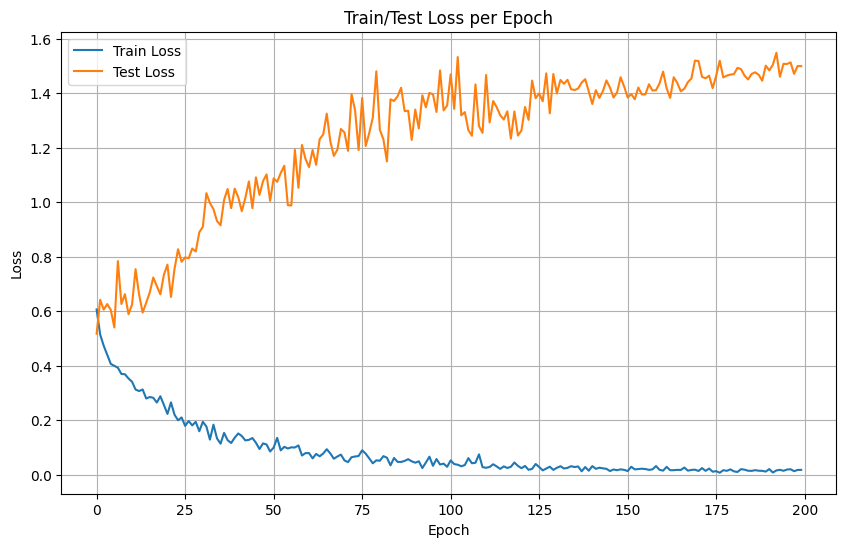

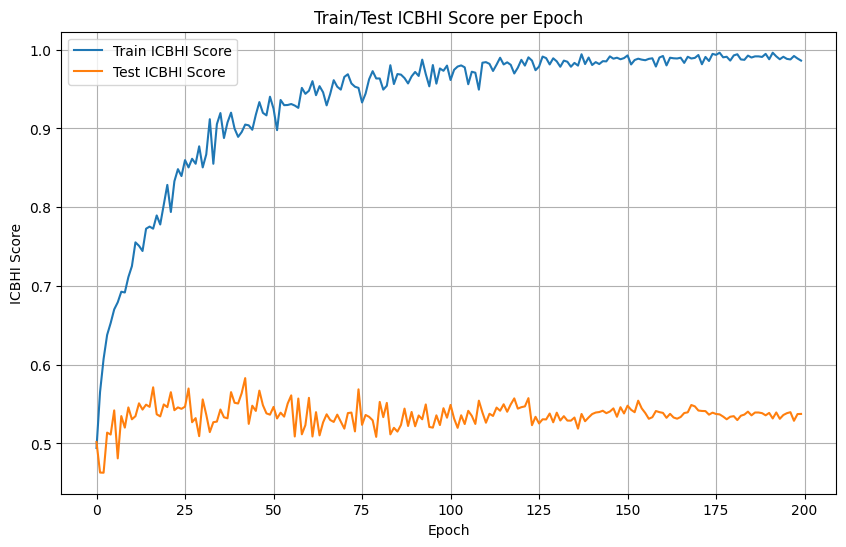


=== [최고 Test ICBHI Score 시점 정보] ===
Best Test ICBHI Score: 0.5829 (Epoch 42)
Test Loss at Best: 1.0154
Confusion Matrix at Best ICBHI Score:
[[1197  206  158   18]
 [ 296  322   16   15]
 [ 181   48  130   26]
 [  53   17   45   28]]
Sensitivity: 0.4078, Specificity: 0.7581, ICBHI Score: 0.5829
Best Epoch: 42


In [36]:
# --- 훈련 종료 후 그래프 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(epochs, train_icbhi_scores, label='Train ICBHI Score')
plt.plot(epochs, test_icbhi_scores, label='Test ICBHI Score')
plt.xlabel('Epoch')
plt.ylabel('ICBHI Score')
plt.title('Train/Test ICBHI Score per Epoch')
plt.legend()
plt.grid(True)
plt.show()

best_epoch_idx = np.argmax(test_icbhi_scores)
best_epoch = epochs[best_epoch_idx]
best_icbhi_score = test_icbhi_scores[best_epoch_idx]
best_test_loss = test_losses[best_epoch_idx]

# 최고점 epoch에서의 labels, preds
best_test_labels = test_labels_all[best_epoch_idx]
best_test_preds = test_preds_all[best_epoch_idx]

best_cm, best_sens, best_spec, best_y_true_cls, best_y_pred_cls = evaluate_multiclass_confusion(
    best_test_labels, best_test_preds)

print("\n=== [최고 Test ICBHI Score 시점 정보] ===")
print(f"Best Test ICBHI Score: {best_icbhi_score:.4f} (Epoch {best_epoch})")
print(f"Test Loss at Best: {best_test_loss:.4f}")
print("Confusion Matrix at Best ICBHI Score:")
print(best_cm)
print(f"Sensitivity: {best_sens:.4f}, Specificity: {best_spec:.4f}, ICBHI Score: {(best_sens+best_spec)/2:.4f}")
print(f"Best Epoch: {best_epoch}")
